# Codes and experiments of "adversarial attack and " for our term project

Codes for experiments are well organized so that each cell represents a single experiment, and above each experiments are comments for each experiment.

In [1]:
import torch
from train import prepare_cifar
from model import ResNet18
import os
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import copy
import pdb
import numpy as np
import random
%matplotlib inline
import matplotlib.pyplot as plt

### load the model

In [3]:
_, testloader = prepare_cifar()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
cudnn.benchmark = True

net_set = []
for i in range(5):
    net_set.append(ResNet18())
    net_set[i] = net_set[i].to(device)
    net_set[i] = torch.nn.DataParallel(net_set[i])
    checkpoint = torch.load("./checkpoint/ckpt_{}.pth".format(i))
    net_set[i].load_state_dict(checkpoint["net"])
    print("{} {}".format(checkpoint["acc"], checkpoint["epoch"]))

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
cuda
94.39 88
94.38 89
94.54 79
94.29 87
94.37 75


### Some util functions

In [7]:
def gen_dif(targets):
    targets = copy.deepcopy(targets.to("cpu").numpy())
    ret = []
    for tar in targets:
        rand_n = random.randint(0, 9)
        if rand_n == tar:
            rand_n = (rand_n + 1) % 10
        ret.append(rand_n)
    return torch.tensor(np.array(ret)).to(device)

def plot_trend(index, acc_x, acc_y, equal_rate, referred, equal, title):
    index = np.array(index)
    indexes = np.arange(1, index.shape[0] + 1)
    acc_x = np.array(acc_x)
    acc_y = np.array(acc_y)
    equal_rate = np.array(equal_rate)
    fig = plt.figure(figsize=(7,7))
    plt.plot(indexes, acc_x, marker='o', linewidth=3, label="targeted_suc_rate", color="r")
    plt.plot(indexes, acc_y, marker='o', linewidth=3, label="untargeted_suc_rate", color="b")
    plt.plot(indexes, equal_rate, marker='o', linewidth=3, label="equal_rate", color="orange")
    plt.plot(indexes, referred, marker='o', linewidth=3, label="ref_suc_rate", color="g")
    plt.plot(indexes, equal, marker="o", linewidth=3, label="ref_equal_rate", color="black")
    plt.title(title)
    plt.yticks(np.arange(0.0, 1.05, 0.05))
    plt.ylabel("accuracy")
    plt.xticks(indexes, index)
    plt.xlabel("norm")
    plt.legend()
    plt.grid()
    plt.show()
    

## Experiment #1
Bad case test.

If two networks are similar, then the intersect / union of bad cases should be ~1, otherwise, the IOU would be small.

This part does not appear in our final paper. However, it is also an indication that two networks are not similar in some local region (in this experiment, neighborhood of the bad case datapoints).

In [15]:
def bad_case(net_set):
    pred_results = []
    gt = np.array([], dtype=np.int32)
    for i in range(5):
        net_set[i].eval()
        results = np.array([], dtype=np.int32)
        with torch.no_grad():
            for batch_idx, (inputs, targets) in enumerate(testloader):
                if i == 0:
                    gt = np.concatenate((gt, targets), axis=0)
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = net_set[i](inputs)
                _, pred = outputs.max(1)
                pred = copy.deepcopy(pred.to("cpu").numpy())
                results = np.concatenate((results, pred), axis=0)
                print(batch_idx)
        print(results.shape)
        pred_results.append(results)
    
    def iou(pred1, pred2, gt):
        inter_sz = 0
        union_sz = 0
        for i in range(pred1.shape[0]):
            if gt[i] != pred1[i] or gt[i] != pred2[i]:
                union_sz += 1
                if pred1[i] == pred2[i]:
                    inter_sz += 1
        return inter_sz / union_sz
    
    def iou2(pred1, pred2, gt):
        inter_sz = 0
        union_sz = 0
        for i in range(pred1.shape[0]):
            if gt[i] != pred1[i] or gt[i] != pred2[i]:
                union_sz += 1
                if gt[i] != pred1[i] and gt[i] != pred2[i]:
                    inter_sz += 1
        return inter_sz / union_sz
    
    for i in range(5):
        for j in range(i + 1, 5):
            print(iou(pred_results[i], pred_results[j], gt), iou2(pred_results[i], pred_results[j], gt))
bad_case(net_set)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
(10000,)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
(10000,)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
(10000,)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
(10000,)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


## experiment 2
"fast gradient 'direction' attack"
We fix the length of the gradient, and update the input with the exact direction of the gradient:
$$I' = norm1(I + norm2(\nabla_I f(I)) - I_0) + I_0$$
Then we check if $I'$ can also fool another neural network.

01234567
0.9296875 0.935546875 0.9384765625 0.9462890625 0.955078125
01234567
0.8935546875 0.9228515625 0.8955078125 0.9453125 0.9541015625
01234567
0.755859375 0.888671875 0.783203125 0.9462890625 0.9541015625
01234567
0.484375 0.7958984375 0.6083984375 0.9423828125 0.951171875
01234567
0.2724609375 0.67578125 0.5 0.943359375 0.947265625
01234567
0.0947265625 0.4833984375 0.5048828125 0.935546875 0.9384765625
01234567
0.0234375 0.2490234375 0.685546875 0.90625 0.8974609375
01234567
0.0068359375 0.060546875 0.810546875 0.59765625 0.6376953125


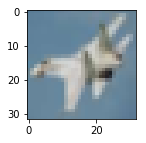

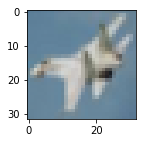

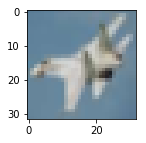

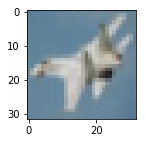

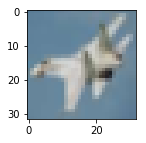

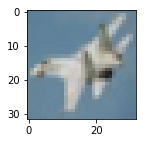

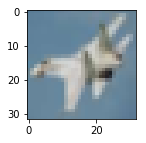

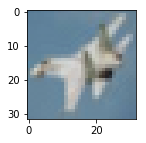

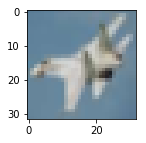

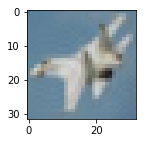

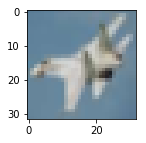

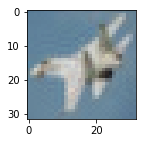

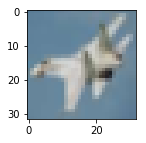

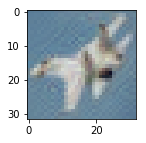

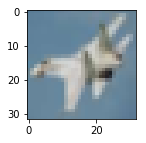

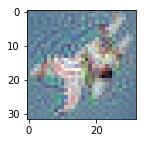

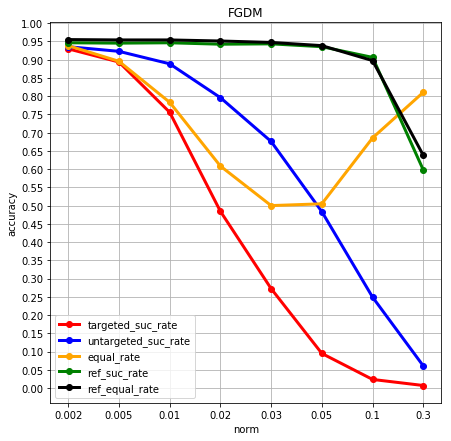

01234567
0.93359375 0.9365234375 0.9326171875 0.9453125 0.94921875
01234567
0.88671875 0.923828125 0.8896484375 0.947265625 0.953125
01234567
0.7666015625 0.8896484375 0.791015625 0.947265625 0.9501953125
01234567
0.4462890625 0.806640625 0.55859375 0.9443359375 0.951171875
01234567
0.263671875 0.6875 0.4951171875 0.9345703125 0.94921875
01234567
0.109375 0.4814453125 0.5283203125 0.93359375 0.9365234375
01234567
0.021484375 0.1962890625 0.7021484375 0.8955078125 0.919921875
01234567
0.00390625 0.064453125 0.80859375 0.6025390625 0.6708984375


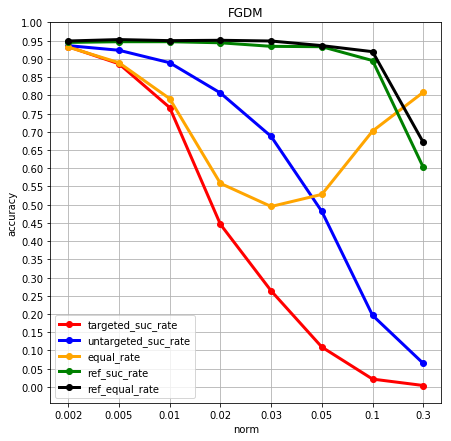

01234567
0.935546875 0.9326171875 0.9365234375 0.9453125 0.9521484375
01234567
0.88671875 0.9208984375 0.8876953125 0.9462890625 0.9521484375
01234567
0.7646484375 0.876953125 0.80078125 0.94921875 0.9482421875
01234567
0.4560546875 0.814453125 0.55859375 0.939453125 0.9462890625
01234567
0.2919921875 0.7001953125 0.4873046875 0.939453125 0.947265625
01234567
0.1201171875 0.5224609375 0.5029296875 0.923828125 0.9404296875
01234567
0.0234375 0.2392578125 0.6796875 0.9013671875 0.91015625
01234567
0.00390625 0.0673828125 0.775390625 0.619140625 0.6943359375


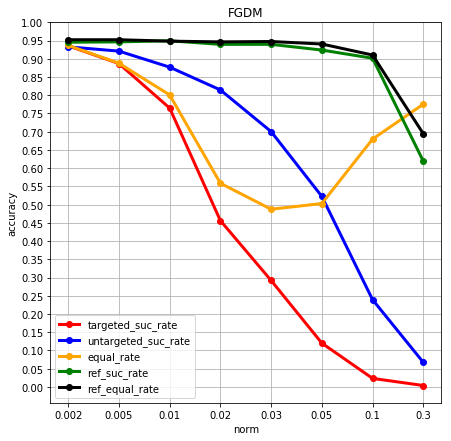

01234567
0.9267578125 0.9384765625 0.93359375 0.9462890625 0.951171875
01234567
0.8896484375 0.9287109375 0.90234375 0.947265625 0.953125
01234567
0.7724609375 0.8857421875 0.80078125 0.9453125 0.951171875
01234567
0.4619140625 0.8046875 0.5771484375 0.9443359375 0.953125
01234567
0.263671875 0.693359375 0.482421875 0.9423828125 0.9453125
01234567
0.099609375 0.505859375 0.486328125 0.921875 0.9287109375
01234567
0.0244140625 0.2529296875 0.6552734375 0.90625 0.9052734375
01234567
0.0126953125 0.068359375 0.7900390625 0.60546875 0.6435546875


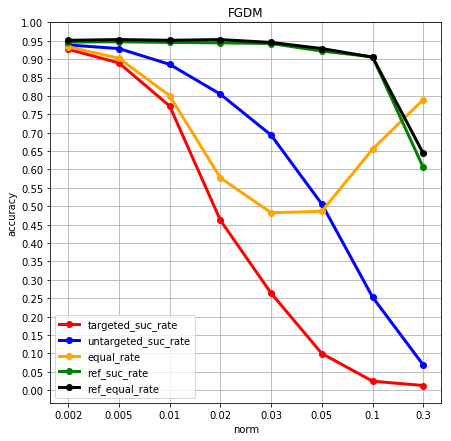

01234567
0.931640625 0.93359375 0.93359375 0.943359375 0.955078125
01234567
0.890625 0.9248046875 0.8994140625 0.943359375 0.9521484375
01234567
0.7431640625 0.8876953125 0.7744140625 0.9423828125 0.951171875
01234567
0.443359375 0.796875 0.5546875 0.94140625 0.9501953125
01234567
0.2275390625 0.669921875 0.4404296875 0.9384765625 0.9423828125
01234567
0.083984375 0.5009765625 0.4658203125 0.9345703125 0.9375
01234567
0.0087890625 0.20703125 0.654296875 0.9091796875 0.9111328125
01234567
0.0 0.0361328125 0.79296875 0.513671875 0.66796875


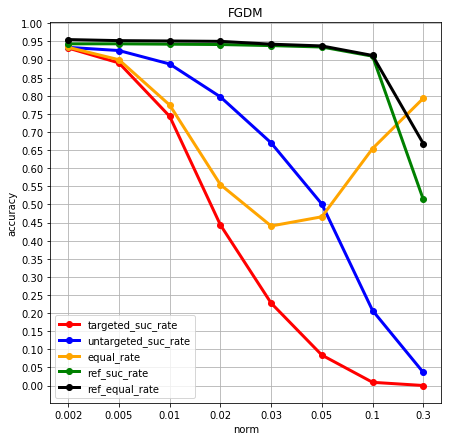

01234567
0.9345703125 0.9326171875 0.927734375 0.9423828125 0.9521484375
01234567
0.8974609375 0.9140625 0.8916015625 0.9423828125 0.9521484375
01234567
0.732421875 0.8876953125 0.7509765625 0.943359375 0.951171875
01234567
0.4150390625 0.79296875 0.533203125 0.9384765625 0.9453125
01234567
0.23046875 0.6962890625 0.4365234375 0.9404296875 0.94921875
01234567
0.09375 0.5068359375 0.4853515625 0.931640625 0.9375
01234567
0.009765625 0.232421875 0.666015625 0.8994140625 0.900390625
01234567
0.0009765625 0.0693359375 0.775390625 0.5341796875 0.6630859375


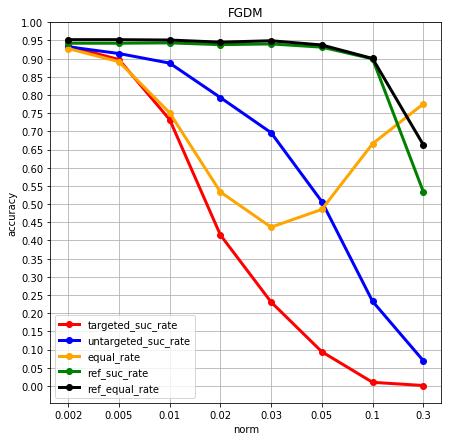

01234567
0.9345703125 0.9384765625 0.9404296875 0.943359375 0.9501953125
01234567
0.8994140625 0.9267578125 0.8935546875 0.943359375 0.947265625
01234567
0.7607421875 0.8857421875 0.7978515625 0.943359375 0.9521484375
01234567
0.4423828125 0.7890625 0.5751953125 0.9423828125 0.9462890625
01234567
0.2294921875 0.6953125 0.439453125 0.935546875 0.939453125
01234567
0.083984375 0.4990234375 0.4794921875 0.9326171875 0.9326171875
01234567
0.013671875 0.220703125 0.6591796875 0.90625 0.88671875
01234567
0.00390625 0.064453125 0.7783203125 0.5400390625 0.677734375


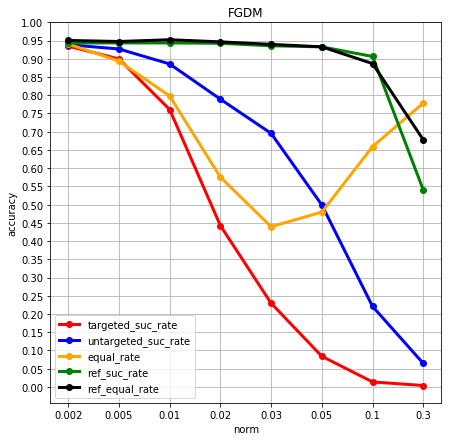

01234567
0.935546875 0.9306640625 0.935546875 0.9443359375 0.9501953125
01234567
0.89453125 0.919921875 0.8916015625 0.943359375 0.947265625
01234567
0.7607421875 0.87890625 0.791015625 0.943359375 0.9501953125
01234567
0.4599609375 0.8076171875 0.560546875 0.9423828125 0.943359375
01234567
0.26171875 0.697265625 0.4794921875 0.9384765625 0.9482421875
01234567
0.08984375 0.5146484375 0.4736328125 0.9345703125 0.935546875
01234567
0.0166015625 0.2294921875 0.6748046875 0.9130859375 0.90234375
01234567
0.00390625 0.06640625 0.77734375 0.580078125 0.6845703125


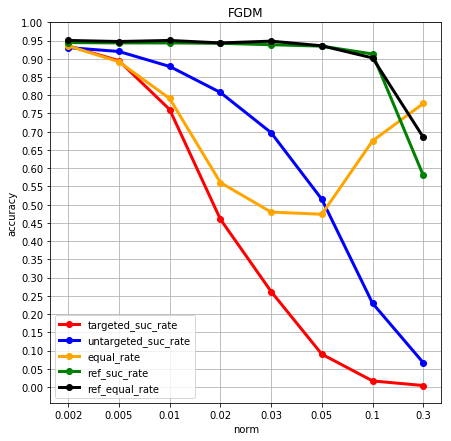

01234567
0.935546875 0.9443359375 0.9482421875 0.943359375 0.9619140625
01234567
0.8955078125 0.93359375 0.9111328125 0.9443359375 0.962890625
01234567
0.7666015625 0.8876953125 0.796875 0.9453125 0.9619140625
01234567
0.46484375 0.7802734375 0.5966796875 0.9443359375 0.9609375
01234567
0.2587890625 0.673828125 0.470703125 0.943359375 0.9482421875
01234567
0.091796875 0.5078125 0.47265625 0.9326171875 0.9384765625
01234567
0.0146484375 0.2001953125 0.6865234375 0.91015625 0.8916015625
01234567
0.00390625 0.060546875 0.76171875 0.580078125 0.673828125


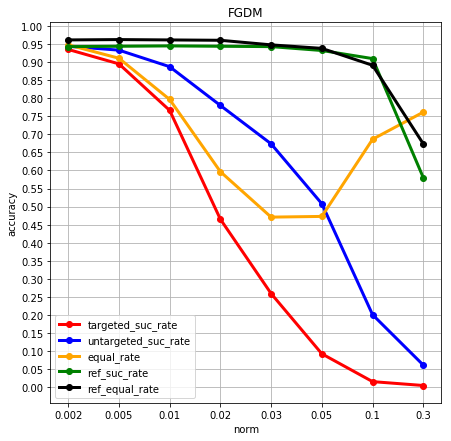

01234567
0.92578125 0.9375 0.9296875 0.9384765625 0.947265625
01234567
0.8896484375 0.923828125 0.9052734375 0.9375 0.9501953125
01234567
0.7529296875 0.8837890625 0.7890625 0.9375 0.94921875
01234567
0.4814453125 0.7900390625 0.6123046875 0.935546875 0.9404296875
01234567
0.296875 0.6806640625 0.529296875 0.9365234375 0.9482421875
01234567
0.1181640625 0.5126953125 0.5029296875 0.9296875 0.9345703125
01234567
0.0322265625 0.2470703125 0.671875 0.8984375 0.9111328125
01234567
0.0068359375 0.0732421875 0.7802734375 0.6005859375 0.6611328125


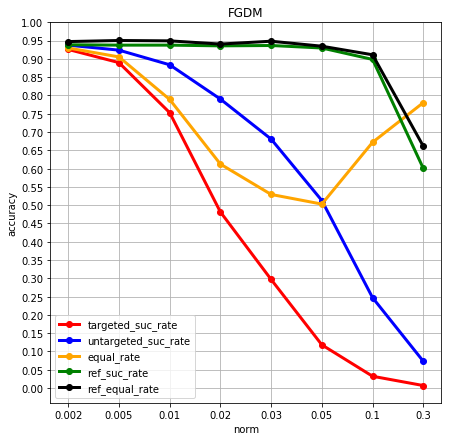

In [11]:
mean_channel = [0.4914, 0.4822, 0.4465]
std_channel = [0.2023, 0.1994, 0.2010]
def restore_fig(img):
    img = copy.deepcopy(img)
    for i in range(3):
        img[i, :, :] = 255 * (img[i, :, :] * std_channel[i] + mean_channel[i] + 1e-5)
    img = np.clip(img, 0, 255)
    
    img = img.astype(np.uint8)
    img = np.swapaxes(img, 0, 1)
    img = np.swapaxes(img, 1, 2)
    return img

def plot_img(img):
    #mport pdb
    #pdb.set_trace()
    plt.figure(figsize=(2, 2))
    plt.imshow(img)

def pertube(net, inps, targets, eps):
    length = 32. * 1.7
    iter_time = 5
    pert = torch.zeros(inps.shape, dtype=torch.float32).to(device)
    
    criterion = nn.CrossEntropyLoss()

    for i in range(iter_time):
        net.zero_grad()
        inputs = torch.autograd.Variable(inps - pert, requires_grad=True)
        outputs = net(inputs)
        #import pdb
        #pdb.set_trace()
        loss = criterion(outputs, targets)
        loss.backward()
        grad = inputs.grad.data
        grad = eps * length / 3 * grad / torch.norm(grad.reshape(targets.shape[0], -1), dim=1).reshape(targets.shape[0], 1, 1, 1)
        pert = pert + grad
        pert = eps * length * pert / torch.norm(pert.reshape(targets.shape[0], -1), dim=1).reshape(targets.shape[0], 1, 1, 1)
        pert = torch.clamp(pert, min=-1, max=1)
        
    return pert

    
def experiment_attack(net_set):
    for i in range(5):
        net_set[i].eval()
    
    for i in range(5):
        for j in range(i + 1, 5):
            acc_x, acc_y, equal_rate = [], [], []
            referred = []
            equal_rate2 = []
            for eps in [2e-3, 5e-3, 1e-2, 2e-2, 3e-2, 5e-2, 1e-1, 3e-1]:
                acc1 = 0
                acc2 = 0
                acc3 = 0
                refer = 0
                equal = 0
                for batch_idx, (inputs, targets) in enumerate(testloader):
                    inps = inputs.to(device)
                    tgts = targets.to(device)
                    fake = gen_dif(targets)
                    pert = pertube(net_set[i], inps, fake, eps)
                    inps -= pert
                    tmp = inps.to("cpu").numpy()
                    #import pdb
                    #pdb.set_trace()
                    if batch_idx == 0 and j == 1:
                        plot_img(restore_fig(inputs[10].numpy()))
                        plot_img(restore_fig(tmp[10]))

                    oup1 = net_set[i](inps)
                    oup2 = net_set[j](inps)
                    _, pred1 = oup1.max(1)
                    _, pred2 = oup2.max(1)
                    acc1 += pred1.eq(tgts).sum().item()
                    acc2 += pred2.eq(tgts).sum().item()
                    acc3 += pred2.eq(pred1).sum().item()
                    
                    inps = inputs.to(device)
                    pert1 = torch.randn(inputs.shape).to(device)
                    pert1 = pert1 / torch.norm(pert1.reshape(targets.shape[0], -1), dim=1).reshape(targets.shape[0], 1, 1, 1)
                    pert2 = torch.randn(inputs.shape).to(device)
                    pert2 = pert2 / torch.norm(pert2.reshape(targets.shape[0], -1), dim=1).reshape(targets.shape[0], 1, 1, 1)
                    oup1 = net_set[i](inps + pert1 * eps * 32. * 1.7)
                    oup2 = net_set[j](inps + pert2 * eps * 32. * 1.7)
                    _, pred1 = oup1.max(1)
                    _, pred2 = oup2.max(1)
                    refer += pred1.eq(tgts).sum().item()
                    equal += pred2.eq(pred1).sum().item()
                    
                    print(batch_idx, end="")
                    if batch_idx >= 7:
                        break
                print("")
                
                acc1 /= 1024
                acc2 /= 1024
                acc3 /= 1024
                refer /= 1024
                equal /= 1024
                acc_x.append(acc1)
                acc_y.append(acc2)
                equal_rate.append(acc3)
                referred.append(refer)
                equal_rate2.append(equal)
                print(acc1, acc2, acc3, refer, equal)
            plot_trend([2e-3, 5e-3, 1e-2, 2e-2, 3e-2, 5e-2, 1e-1, 3e-1], acc_x, acc_y, equal_rate, referred, equal_rate2, "FGDM")

                    
                
experiment_attack(net_set)

## experiment 3
Fast gradient sign method.
Similar with experiment 2, we still fix the norm of pertubation and compare the fool rate of the targeted network and the untargeted network & equal rate of the predicted label.

01234567
0.919921875 0.9296875 0.92578125 0.9462890625 0.9560546875
01234567
0.8583984375 0.9189453125 0.8701171875 0.9443359375 0.953125
01234567
0.6123046875 0.8798828125 0.6728515625 0.9404296875 0.9501953125
01234567
0.380859375 0.8427734375 0.4697265625 0.9375 0.94921875
01234567
0.1259765625 0.703125 0.3388671875 0.93359375 0.9365234375
01234567
0.013671875 0.3818359375 0.5234375 0.904296875 0.9140625
01234567
0.0048828125 0.0966796875 0.775390625 0.60546875 0.62109375


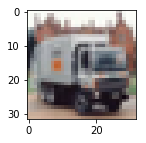

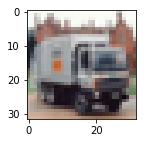

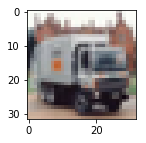

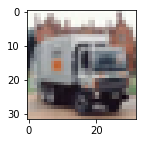

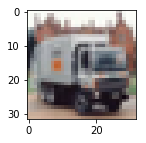

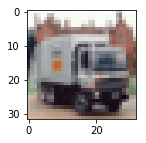

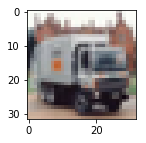

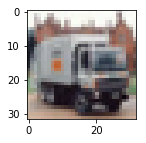

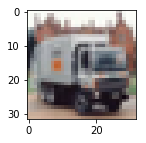

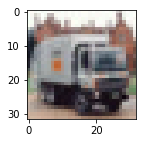

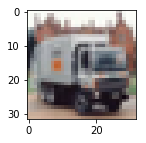

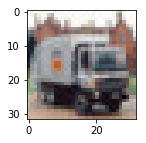

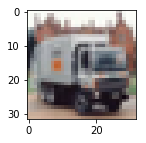

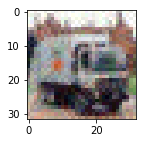

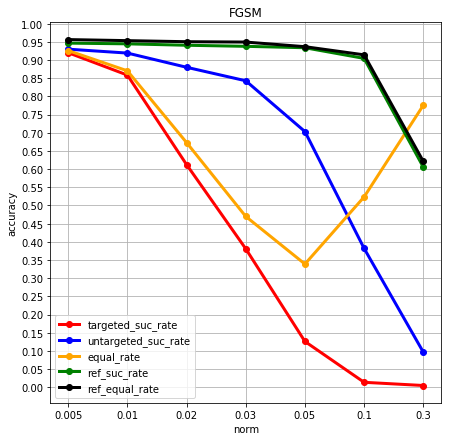

01234567
0.9189453125 0.93359375 0.9189453125 0.947265625 0.9501953125
01234567
0.8447265625 0.91796875 0.8564453125 0.9453125 0.953125
01234567
0.5986328125 0.8818359375 0.65625 0.9462890625 0.951171875
01234567
0.3544921875 0.81640625 0.4697265625 0.9453125 0.9462890625
01234567
0.119140625 0.6826171875 0.3486328125 0.9306640625 0.9443359375
01234567
0.0244140625 0.396484375 0.5185546875 0.9052734375 0.9091796875
01234567
0.0048828125 0.0927734375 0.787109375 0.6083984375 0.6904296875


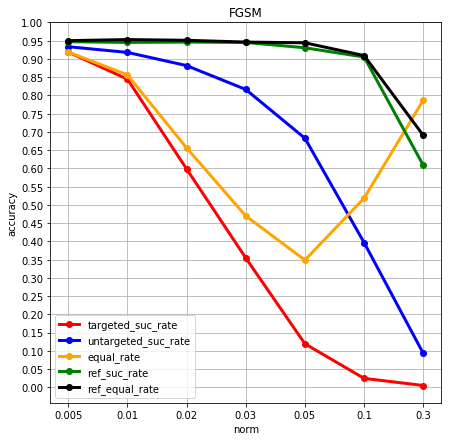

01234567
0.9228515625 0.9306640625 0.9345703125 0.9462890625 0.9541015625
01234567
0.8505859375 0.9169921875 0.869140625 0.9453125 0.951171875
01234567
0.5732421875 0.876953125 0.62890625 0.9443359375 0.9404296875
01234567
0.353515625 0.8232421875 0.4580078125 0.9423828125 0.943359375
01234567
0.126953125 0.708984375 0.337890625 0.92578125 0.939453125
01234567
0.0234375 0.43359375 0.4755859375 0.9033203125 0.9072265625
01234567
0.0029296875 0.0986328125 0.76171875 0.6201171875 0.6728515625


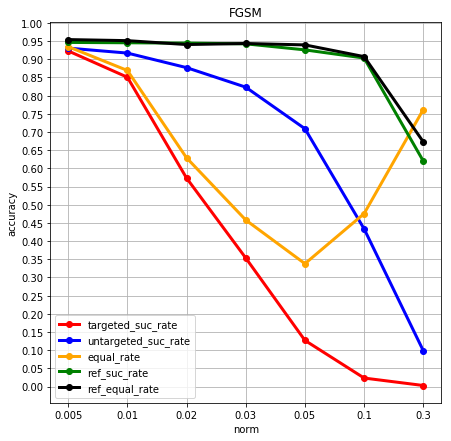

01234567
0.9140625 0.9384765625 0.919921875 0.947265625 0.9521484375
01234567
0.845703125 0.92578125 0.865234375 0.9443359375 0.953125
01234567
0.6123046875 0.87890625 0.6669921875 0.9423828125 0.9501953125
01234567
0.3701171875 0.8125 0.4912109375 0.939453125 0.94140625
01234567
0.1318359375 0.6904296875 0.345703125 0.9296875 0.939453125
01234567
0.0234375 0.3955078125 0.513671875 0.9052734375 0.8916015625
01234567
0.005859375 0.1162109375 0.7373046875 0.6103515625 0.658203125


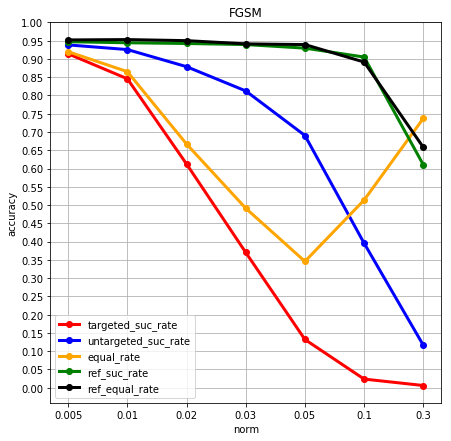

01234567
0.9228515625 0.935546875 0.9208984375 0.943359375 0.9521484375
01234567
0.8486328125 0.9248046875 0.869140625 0.94140625 0.9521484375
01234567
0.59765625 0.8779296875 0.6474609375 0.939453125 0.9521484375
01234567
0.3701171875 0.814453125 0.4814453125 0.9404296875 0.951171875
01234567
0.107421875 0.68359375 0.318359375 0.935546875 0.93359375
01234567
0.0146484375 0.359375 0.5107421875 0.8974609375 0.90625
01234567
0.001953125 0.060546875 0.783203125 0.5302734375 0.64453125


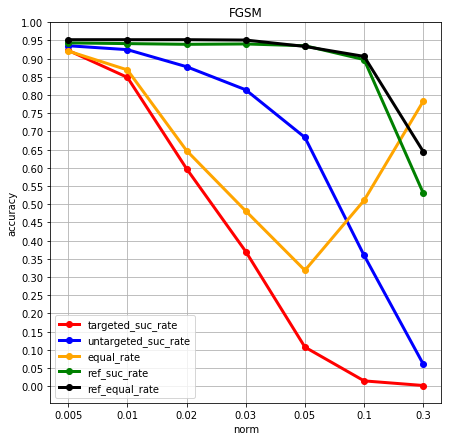

01234567
0.919921875 0.9287109375 0.91796875 0.943359375 0.9501953125
01234567
0.8515625 0.9111328125 0.865234375 0.9423828125 0.951171875
01234567
0.6083984375 0.8798828125 0.669921875 0.94140625 0.9501953125
01234567
0.353515625 0.8203125 0.4619140625 0.939453125 0.9501953125
01234567
0.1181640625 0.697265625 0.3154296875 0.9345703125 0.9443359375
01234567
0.015625 0.3935546875 0.5087890625 0.896484375 0.900390625
01234567
0.0009765625 0.091796875 0.7919921875 0.5322265625 0.671875


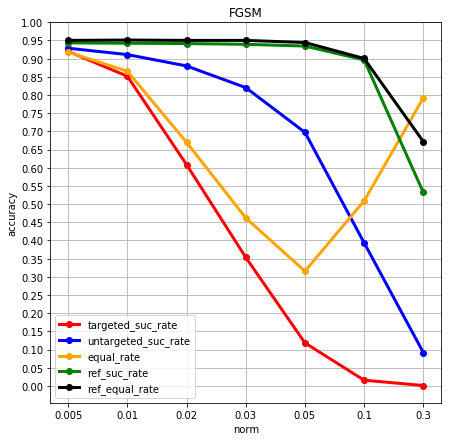

01234567
0.9169921875 0.9375 0.919921875 0.9423828125 0.9482421875
01234567
0.8642578125 0.927734375 0.8759765625 0.9423828125 0.94921875
01234567
0.5966796875 0.8701171875 0.6494140625 0.9404296875 0.9443359375
01234567
0.373046875 0.8125 0.484375 0.9375 0.94140625
01234567
0.10546875 0.6953125 0.3134765625 0.9306640625 0.9326171875
01234567
0.01953125 0.3974609375 0.50390625 0.8955078125 0.8984375
01234567
0.0029296875 0.119140625 0.7373046875 0.5185546875 0.6748046875


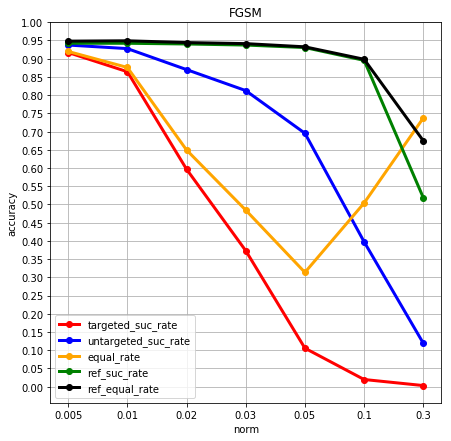

01234567
0.921875 0.9287109375 0.91796875 0.9443359375 0.9501953125
01234567
0.8525390625 0.9072265625 0.8662109375 0.9462890625 0.94921875
01234567
0.6025390625 0.8681640625 0.6572265625 0.9423828125 0.953125
01234567
0.3955078125 0.822265625 0.490234375 0.9404296875 0.94921875
01234567
0.1015625 0.68359375 0.333984375 0.9384765625 0.9423828125
01234567
0.009765625 0.4189453125 0.45703125 0.904296875 0.904296875
01234567
0.0029296875 0.1083984375 0.7314453125 0.5810546875 0.6806640625


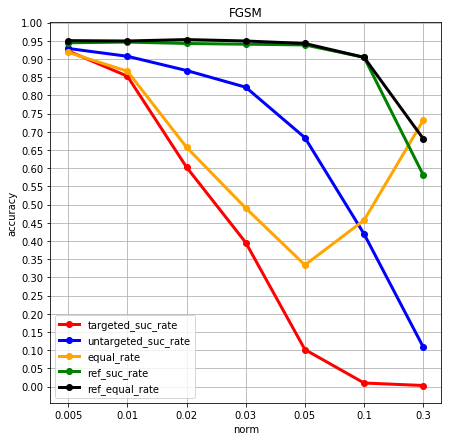

01234567
0.9169921875 0.93359375 0.92578125 0.943359375 0.9619140625
01234567
0.85546875 0.9267578125 0.869140625 0.9443359375 0.9658203125
01234567
0.62109375 0.8759765625 0.669921875 0.94140625 0.9609375
01234567
0.388671875 0.8125 0.4892578125 0.935546875 0.9541015625
01234567
0.1142578125 0.67578125 0.3466796875 0.9326171875 0.94140625
01234567
0.015625 0.421875 0.4755859375 0.9091796875 0.8955078125
01234567
0.00390625 0.130859375 0.7158203125 0.576171875 0.6494140625


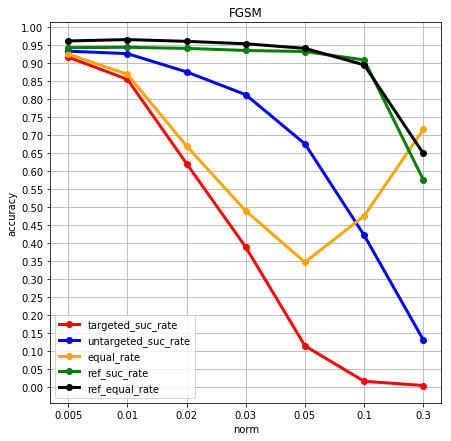

01234567
0.9169921875 0.9326171875 0.9345703125 0.9365234375 0.94921875
01234567
0.849609375 0.92578125 0.8623046875 0.935546875 0.9482421875
01234567
0.6103515625 0.869140625 0.6708984375 0.935546875 0.9462890625
01234567
0.390625 0.8017578125 0.521484375 0.9345703125 0.939453125
01234567
0.1357421875 0.6611328125 0.380859375 0.9326171875 0.9423828125
01234567
0.0244140625 0.412109375 0.4794921875 0.904296875 0.8955078125
01234567
0.00390625 0.1357421875 0.7001953125 0.6328125 0.6748046875


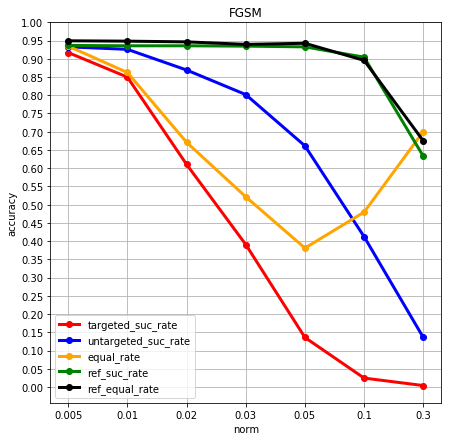

In [12]:
mean_channel = [0.4914, 0.4822, 0.4465]
std_channel = [0.2023, 0.1994, 0.2010]
def restore_fig(img):
    img = copy.deepcopy(img)
    for i in range(3):
        img[i, :, :] = 255 * (img[i, :, :] * std_channel[i] + mean_channel[i] + 1e-5)
    img = np.clip(img, 0, 255)
    
    img = img.astype(np.uint8)
    img = np.swapaxes(img, 0, 1)
    img = np.swapaxes(img, 1, 2)
    return img

def plot_img(img):
    #mport pdb
    #pdb.set_trace()
    plt.figure(figsize=(2, 2))
    plt.imshow(img)

def pertube(net, inps, targets, eps):
    length = 32. * 1.7
    eps2 = eps / 5 * 3
    iter_time = 10
    pert = torch.zeros(inps.shape, dtype=torch.float32).to(device)
    
    criterion = nn.CrossEntropyLoss()

    for i in range(iter_time):
        net.zero_grad()
        inputs = torch.autograd.Variable(inps - pert, requires_grad=True)
        outputs = net(inputs)
        #import pdb
        #pdb.set_trace()
        loss = criterion(outputs, targets)
        #print(loss)
        loss.backward()
        grad = torch.sign(inputs.grad.data) * eps2
        pert = torch.clamp(pert + grad, min=-eps, max=eps)
        #pert = eps * length * pert / torch.norm(pert.reshape(targets.shape[0], -1), dim=1).reshape(targets.shape[0], 1, 1, 1)

    return pert

    
def experiment_attack2(net_set):
    for i in range(5):
        net_set[i].eval()
    
    for i in range(5):
        for j in range(i + 1, 5):
            acc_x, acc_y, equal_rate = [], [], []
            referred = []
            equal_rate2 = []
            for eps in [5e-3, 1e-2, 2e-2, 3e-2, 5e-2, 1e-1, 3e-1]:
                acc1 = 0
                acc2 = 0
                acc3 = 0
                refer = 0
                equal = 0
                for batch_idx, (inputs, targets) in enumerate(testloader):
                    inps = inputs.to(device)
                    tgts = targets.to(device)
                    fake = gen_dif(targets)
                    pert = pertube(net_set[i], inps, fake, eps)
                    inps -= pert
                    tmp = inps.to("cpu").numpy()
                    #import pdb
                    #pdb.set_trace()
                    if batch_idx == 0 and j == 1:
                        plot_img(restore_fig(inputs[11].numpy()))
                        plot_img(restore_fig(tmp[11]))

                    oup1 = net_set[i](inps)
                    oup2 = net_set[j](inps)
                    _, pred1 = oup1.max(1)
                    _, pred2 = oup2.max(1)
                    acc1 += pred1.eq(tgts).sum().item()
                    acc2 += pred2.eq(tgts).sum().item()
                    acc3 += pred2.eq(pred1).sum().item()
                
                    inps = inputs.to(device)
                    pert1 = torch.randn(inputs.shape).to(device)
                    pert1 = pert1 / torch.norm(pert1.reshape(targets.shape[0], -1), dim=1).reshape(targets.shape[0], 1, 1, 1)
                    pert2 = torch.randn(inputs.shape).to(device)
                    pert2 = pert2 / torch.norm(pert2.reshape(targets.shape[0], -1), dim=1).reshape(targets.shape[0], 1, 1, 1)
                    oup1 = net_set[i](inps + pert1 * eps * 32. * 1.7)
                    oup2 = net_set[j](inps + pert2 * eps * 32. * 1.7)
                    _, pred1 = oup1.max(1)
                    _, pred2 = oup2.max(1)
                    refer += pred1.eq(tgts).sum().item()
                    equal += pred2.eq(pred1).sum().item()
                    
                    print(batch_idx, end="")
                    if batch_idx >= 7:
                        break
                print("")
                
                acc1 /= 1024
                acc2 /= 1024
                acc3 /= 1024
                refer /= 1024
                equal /= 1024
                acc_x.append(acc1)
                acc_y.append(acc2)
                equal_rate.append(acc3)
                referred.append(refer)
                equal_rate2.append(equal)
                print(acc1, acc2, acc3, refer, equal)
            plot_trend([5e-3, 1e-2, 2e-2, 3e-2, 5e-2, 1e-1, 3e-1], acc_x, acc_y, equal_rate, referred, equal_rate2, "FGSM")

                    
                
experiment_attack2(net_set)

## experiment #4
In order to demonstrate the property of one data point's neighborhood boundary, we randomly select directions and measure the distance to the boundary. 

Two networks are similar => Given the direction, distances to the boundary are similar, and with high probability, the neighborhood class outside the boundary is the same one.

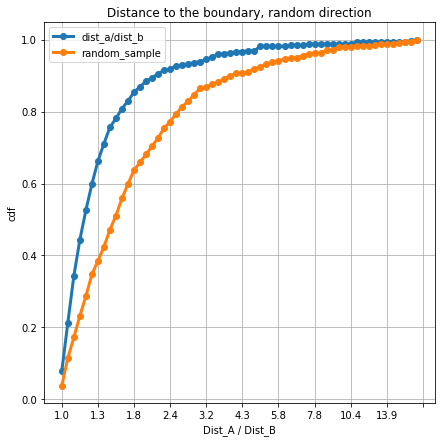

In [3]:
mean_channel = [0.4914, 0.4822, 0.4465]
std_channel = [0.2023, 0.1994, 0.2010]
def restore_fig(img):
    img = copy.deepcopy(img)
    for i in range(3):
        img[i, :, :] = 255 * (img[i, :, :] * std_channel[i] + mean_channel[i] + 1e-5)
    img = np.clip(img, 0, 255)
    
    img = img.astype(np.uint8)
    img = np.swapaxes(img, 0, 1)
    img = np.swapaxes(img, 1, 2)
    return img

def plot_img(img):
    #mport pdb
    #pdb.set_trace()
    plt.figure(figsize=(2, 2))
    plt.imshow(img)

import random
eps = [5e-4]
power = 1.05
powers = [1]
while eps[-1] <= 0.3:
    eps.append(eps[-1] * power)
    powers.append(powers[-1]*power)


def experiment_attack3(net_set):
    for i in range(5):
        net_set[i].eval()
    
    for i in range(2):
        for j in range(i + 1, 2):
            ratio = []
            acc = 0
            for batch_idx, (inputs, targets) in enumerate(testloader):
                inputs = inputs.to(device)
                targets = targets.to(device)
                pert = torch.randn(inputs.shape).to(device)
                pert = pert / torch.norm(pert.reshape(targets.shape[0], -1), dim=1).reshape(targets.shape[0], 1, 1, 1)
                
                if batch_idx == 0:
                    inps = copy.deepcopy((inputs + pert * 1 * 32 * 1.7)[10].to("cpu").numpy())
                    pdb.set_trace()
                    #plot_img(restore_fig(inps))
                
                result1 = []
                result2 = []
                predict1 = []
                predict2 = []
                for eps_i in range(len(eps)):
                    inps = inputs + pert * eps[eps_i] * 32. * 1.7
                    tmp = inps.to("cpu").numpy()

                    oup1 = net_set[i](inps)
                    oup2 = net_set[j](inps)
                    _, pred1 = oup1.max(1)
                    _, pred2 = oup2.max(1)
                    res1 = copy.deepcopy(pred1.eq(targets).to("cpu").numpy())
                    res2 = copy.deepcopy(pred2.eq(targets).to("cpu").numpy())
                    result1.append(res1)
                    result2.append(res2)
                    predict1.append(copy.deepcopy(pred1.to("cpu").numpy()))
                    predict2.append(copy.deepcopy(pred2.to("cpu").numpy()))
                
                result1 = np.array(result1)
                result2 = np.array(result2)
                predict1 = np.array(predict1)
                predict2 = np.array(predict2)
                #pdb.set_trace()
                for sample in range(targets.shape[0]):
                    first_i = 0
                    first_j = 0
                    for eps_i in range(len(eps)):
                        if result1[eps_i][sample] == 0 and not first_i:
                            first_i = eps_i + 1
                        if result2[eps_i][sample] == 0 and not first_j:
                            first_j = eps_i + 1
                    if not first_i:
                        first_i = len(eps)
                    if not first_j:
                        first_j = len(eps)
                    if first_i > first_j:
                        first_i2, first_j2 = first_j, first_i
                    else:
                        first_i2, first_j2 = first_i, first_j
                    
                    if first_i2 > 1 and first_j2 < len(eps):
                        #pdb.set_trace()
                        ratio.append([eps[first_j2 - 1] / eps[first_i2 - 1], first_i2, first_j2])
                        acc += predict1[first_i - 1][sample] == predict2[first_j - 1][sample]
                print(batch_idx)
                if batch_idx >= 8:
                    break
            #pdb.set_trace()
            print(acc / len(ratio))
            return ratio
        
#ratio = experiment_attack3(net_set)
ratio = [[1.2155062500000002, 119, 123], [1.4774554437890632, 122, 130], [1.4774554437890632, 124, 132], [1.1025, 118, 120], [1.2155062500000005, 125, 129], [1.05, 125, 126], [2.078928179411368, 107, 122], [1.2155062500000002, 118, 122], [1.05, 124, 125], [1.0, 129, 129], [1.0, 130, 130], [1.2762815625000001, 118, 123], [1.05, 130, 131], [1.1576250000000003, 128, 131], [2.4066192336910848, 106, 124], [1.7103393581163142, 118, 129], [1.1025, 126, 128], [2.292018317801034, 115, 132], [1.21550625, 115, 119], [1.2762815625000006, 126, 131], [1.4774554437890628, 106, 114], [1.2762815625000004, 122, 127], [1.05, 129, 130], [1.9799315994393978, 108, 122], [1.05, 126, 127], [1.05, 114, 115], [1.05, 128, 129], [1.4774554437890626, 113, 121], [1.1025000000000003, 125, 127], [1.05, 131, 132], [1.9799315994393987, 88, 102], [1.05, 127, 128], [1.3400956406250006, 126, 132], [1.2155062500000005, 126, 130], [2.9252607199217255, 110, 132], [1.7103393581163142, 118, 129], [1.477455443789063, 120, 128], [1.1576250000000001, 123, 126], [1.05, 130, 131], [1.2762815625000004, 122, 127], [1.3400956406250006, 126, 132], [1.1025, 101, 103], [1.4071004226562502, 115, 122], [1.0, 124, 124], [1.3400956406250006, 126, 132], [1.05, 129, 130], [1.79585632602213, 96, 108], [1.4774554437890626, 114, 122], [1.05, 130, 131], [1.05, 130, 131], [1.05, 130, 131], [1.3400956406250006, 125, 131], [5.003188542033791, 84, 117], [1.05, 122, 123], [1.0, 129, 129], [5.003188542033794, 67, 100], [2.6532977051444218, 111, 131], [1.1025, 126, 128], [3.3863549408993876, 107, 132], [1.1576250000000003, 128, 131], [1.1025000000000003, 128, 130], [1.885649142323236, 112, 125], [1.3400956406250006, 126, 132], [1.3400956406250004, 123, 129], [1.340095640625, 114, 120], [1.8856491423232364, 116, 129], [1.2155062500000002, 124, 128], [1.2762815625000001, 123, 128], [1.05, 125, 126], [1.157625, 112, 115], [1.2155062500000002, 124, 128], [1.0, 121, 121], [1.0, 130, 130], [1.7958563260221296, 104, 116], [1.05, 127, 128], [1.05, 128, 129], [1.4071004226562507, 125, 132], [1.1025, 119, 121], [1.157625, 116, 119], [1.05, 130, 131], [2.1828745883819374, 92, 108], [1.3400956406250006, 126, 132], [1.21550625, 111, 115], [1.3400956406250002, 102, 108], [6.385477289908985, 82, 120], [1.05, 127, 128], [1.0, 126, 126], [1.0, 102, 102], [3.0715237559178123, 77, 100], [1.4071004226562502, 117, 124], [1.1576250000000001, 109, 112], [1.1576250000000003, 127, 130], [10.921333129289236, 81, 130], [1.05, 128, 129], [1.551328215978516, 115, 124], [2.182874588381937, 116, 132], [1.6288946267774418, 102, 112], [3.225099943713702, 94, 118], [1.2155062500000002, 107, 111], [1.2155062500000005, 128, 132], [1.3400956406250002, 110, 116], [1.1025, 130, 132], [1.05, 126, 127], [1.05, 123, 124], [1.1025, 130, 132], [1.05, 126, 127], [1.4774554437890628, 118, 126], [1.1025, 124, 126], [1.1025, 126, 128], [1.551328215978516, 117, 126], [1.7103393581163147, 91, 102], [1.1025000000000003, 127, 129], [1.3400956406250006, 124, 130], [1.05, 129, 130], [1.1025000000000003, 129, 131], [1.2155062500000002, 122, 126], [1.4774554437890628, 115, 123], [1.6288946267774422, 94, 104], [1.05, 128, 129], [1.05, 116, 117], [1.05, 129, 130], [1.05, 128, 129], [1.05, 116, 117], [1.40710042265625, 112, 119], [1.6288946267774422, 119, 129], [10.921333129289236, 72, 121], [5.003188542033791, 96, 129], [1.7103393581163147, 121, 132], [1.2762815625000004, 124, 129], [3.555672687944356, 102, 128], [1.0, 122, 122], [1.4774554437890626, 110, 118], [1.05, 128, 129], [1.710339358116314, 115, 126], [1.2762815625000004, 122, 127], [1.2155062500000002, 106, 110], [1.1576250000000001, 124, 127], [1.1025000000000003, 129, 131], [1.1025000000000003, 129, 131], [1.7958563260221299, 115, 127], [2.5269501953756395, 104, 123], [1.0, 130, 130], [1.2762815625000006, 125, 130], [1.05, 129, 130], [1.1025, 130, 132], [1.2155062500000005, 126, 130], [1.0, 128, 128], [1.6288946267774422, 122, 132], [1.1025, 130, 132], [1.3400956406250004, 123, 129], [5.003188542033791, 96, 129], [1.477455443789063, 97, 105], [1.0, 118, 118], [3.225099943713702, 105, 129], [1.7958563260221296, 102, 114], [1.628894626777442, 118, 128], [1.1025, 124, 126], [1.1576250000000003, 128, 131], [1.2762815625000001, 120, 125], [1.2155062500000005, 126, 130], [1.4071004226562507, 125, 132], [1.477455443789063, 121, 129], [1.1025, 119, 121], [1.1025, 120, 122], [1.1576250000000003, 129, 132], [1.2762815625, 115, 120], [1.0, 110, 110], [1.05, 129, 130], [1.79585632602213, 82, 94], [1.4071004226562507, 125, 132], [1.6288946267774418, 101, 111], [1.5513282159785164, 120, 129], [1.1025, 124, 126], [2.182874588381937, 114, 130], [1.0, 121, 121], [1.1025000000000003, 125, 127], [1.2155062500000002, 99, 103], [1.1025, 121, 123], [1.7103393581163147, 121, 132], [1.1025000000000003, 129, 131], [1.40710042265625, 112, 119], [1.1576250000000003, 126, 129], [1.05, 126, 127], [1.2155062500000005, 127, 131], [1.1576250000000001, 122, 125], [1.157625, 114, 117], [1.0, 131, 131], [1.628894626777442, 117, 127], [2.5269501953756395, 108, 127], [1.3400956406250002, 117, 123], [1.9799315994393978, 104, 118], [1.0, 126, 126], [2.2920183178010336, 114, 131], [1.885649142323236, 113, 126], [1.0, 131, 131], [1.3400956406250004, 120, 126], [1.157625, 114, 117], [1.1576250000000003, 126, 129], [1.2155062500000005, 125, 129], [1.7958563260221294, 112, 124], [1.21550625, 115, 119], [1.2762815625000001, 123, 128], [1.1576250000000003, 127, 130], [1.3400956406250002, 107, 113], [1.9799315994393978, 104, 118], [1.05, 128, 129], [1.2155062500000002, 121, 125], [1.1576250000000001, 122, 125], [1.551328215978516, 119, 128], [1.1576250000000001, 118, 121], [1.1576250000000001, 121, 124], [1.2762815625000001, 118, 123], [1.05, 130, 131], [2.2920183178010336, 112, 129], [1.0, 119, 119], [1.1025, 122, 124], [3.9201291384586554, 80, 108], [1.2155062500000002, 119, 123], [1.1025, 114, 116], [2.182874588381937, 114, 130], [1.2762815625000001, 106, 111], [1.6288946267774418, 107, 117], [1.0, 115, 115], [2.5269501953756395, 110, 129], [1.2762815625000001, 118, 123], [1.1025, 126, 128], [1.1576250000000003, 129, 132], [1.0, 117, 117], [1.0, 129, 129], [1.7103393581163138, 113, 124], [1.40710042265625, 114, 121], [1.05, 127, 128], [1.1025000000000003, 128, 130], [1.340095640625, 113, 119], [1.1576250000000003, 128, 131], [1.1025, 130, 132], [1.551328215978516, 119, 128], [1.4774554437890632, 123, 131], [1.1576250000000003, 126, 129], [1.2155062500000005, 125, 129], [1.4774554437890632, 122, 130], [3.3863549408993876, 93, 118], [4.5380394939082, 87, 118], [1.4071004226562505, 120, 127], [1.2155062500000002, 107, 111], [1.1576250000000003, 127, 130], [1.3400956406250002, 118, 124], [1.3400956406250004, 82, 88], [1.2155062500000002, 108, 112], [1.6288946267774418, 107, 117], [1.1025, 117, 119], [1.05, 119, 120], [1.885649142323236, 109, 122], [1.2762815625000004, 127, 132], [1.2155062500000005, 126, 130], [7.391988147730888, 84, 125], [1.05, 118, 119], [1.4071004226562507, 124, 131], [1.2762815625000001, 123, 128], [1.1025000000000003, 127, 129], [1.1025, 114, 116], [1.1025, 124, 126], [1.2762815625000004, 122, 127], [1.1025000000000003, 128, 130], [1.2762815625000001, 123, 128], [1.4071004226562502, 119, 126], [1.05, 115, 116], [1.1576250000000001, 124, 127], [2.078928179411368, 113, 128], [1.2762815625000006, 126, 131], [1.5513282159785164, 123, 132], [1.4774554437890626, 114, 122], [1.2762815625, 115, 120], [1.1576250000000001, 106, 109], [1.4071004226562502, 108, 115], [1.1576250000000001, 124, 127], [1.2762815625000004, 124, 129], [20.593802448270598, 64, 126], [1.0, 129, 129], [1.3400956406250002, 111, 117], [1.0, 126, 126], [1.1025000000000003, 125, 127], [1.0, 121, 121], [1.05, 121, 122], [1.1025, 130, 132], [1.4071004226562505, 90, 97], [2.7859625904016427, 96, 117], [1.4071004226562502, 108, 115], [1.477455443789063, 120, 128], [1.1576250000000003, 126, 129], [1.1576250000000001, 119, 122], [1.1025, 130, 132], [1.2762815625000001, 108, 113], [1.40710042265625, 113, 120], [1.157625, 112, 115], [1.2155062500000005, 127, 131], [1.1025, 130, 132], [4.116135595381587, 98, 127], [1.1025, 108, 110], [2.078928179411368, 110, 125], [1.9799315994393978, 111, 125], [1.0, 128, 128], [1.2155062500000005, 125, 129], [1.2155062500000002, 119, 123], [1.1576250000000001, 122, 125], [1.1576250000000003, 127, 130], [3.555672687944357, 105, 131], [1.5513282159785158, 113, 122], [1.2762815625000001, 109, 114], [1.0, 113, 113], [1.5513282159785162, 96, 105], [1.1025, 130, 132], [3.555672687944357, 105, 131], [1.1576250000000001, 121, 124], [16.942572239567337, 67, 125], [1.8856491423232369, 90, 103], [1.05, 109, 110], [1.4071004226562502, 118, 125], [1.7958563260221296, 110, 122], [1.05, 121, 122], [1.3400956406250004, 123, 129], [1.3400956406250002, 122, 128], [1.1025, 130, 132], [1.2762815625000004, 124, 129], [1.1025, 117, 119], [1.1576250000000001, 125, 128], [1.7958563260221294, 109, 121], [1.1025, 130, 132], [1.05, 121, 122]]
bins = np.zeros(60)
for item in ratio:
    bins[min(59, item[2] - item[1])] += 1
for i in range(1, 60):
    bins[i] += bins[i - 1]
bins /= bins[-1]
bins2 = bins
    
index = np.array(powers[0:60])
plt.figure(figsize=(7,7))
plt.plot(np.arange(60), bins, marker='o', linewidth=3, label="dist_a/dist_b")

bins = np.zeros(60)
for i in range(1000):
    x = random.randint(0, len(ratio) - 1)
    y = random.randint(0, len(ratio) - 1)
    bins[min(59, abs(ratio[x][1] - ratio[y][1]))] += 1
for i in range(1, 60):
    bins[i] += bins[i - 1]
bins /= bins[-1]
index = np.around(np.array(powers[0:60]), decimals=1)

plt.plot(np.arange(60), bins, marker='o', linewidth=3, label="random_sample")
plt.xticks(np.arange(11) * 6, index[0:-1:6])
plt.xlabel("Dist_A / Dist_B")
plt.ylabel("cdf")
plt.title("Distance to the boundary, random direction")
plt.grid()
plt.legend()
plt.show()

### experiment #5
We measure the distance to the boundary in **adversarial direction** in this experiment. Experiment settings are similar with experiment #4 except that we choose the adversarial direction this time.

0
1
2
3
4
5
6
7


No handles with labels found to put in legend.


8
[[1.05, 141, 142], [1.3400956406250006, 124, 130], [1.5513282159785167, 51, 60], [73.22482090623744, 54, 142], [10.921333129289232, 77, 126], [13.274948676983128, 79, 132], [1.1025, 109, 111], [27.59766488481989, 74, 142], [1.8856491423232369, 69, 82], [1.2762815625000004, 128, 133], [1.4774554437890628, 118, 126], [1.21550625, 113, 117], [1.4071004226562505, 90, 97], [1.0, 128, 128], [1.340095640625, 60, 66], [1.979931599439399, 91, 105], [1.3400956406250006, 56, 62], [1.05, 139, 140], [13.274948676983135, 54, 107], [1.8856491423232369, 51, 64], [5.25334796913548, 99, 133], [1.340095640625, 114, 120], [7.391988147730889, 101, 142], [1.0, 120, 120], [1.3400956406250006, 56, 62], [1.0, 116, 116], [2.0789281794113688, 118, 133], [1.4774554437890632, 67, 75], [2.406619233691086, 63, 81], [1.1576250000000001, 130, 133], [1.3400956406250002, 136, 142], [2.406619233691085, 97, 115], [6.385477289908987, 72, 110], [1.1576250000000001, 132, 135], [1.7103393581163144, 45, 56], [1.1025, 130, 13

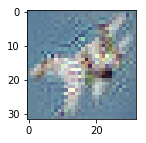

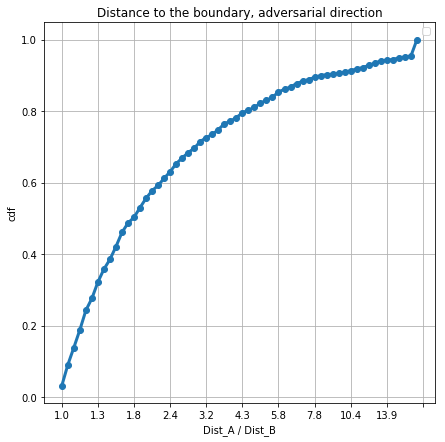

In [8]:
mean_channel = [0.4914, 0.4822, 0.4465]
std_channel = [0.2023, 0.1994, 0.2010]
def restore_fig(img):
    img = copy.deepcopy(img)
    for i in range(3):
        img[i, :, :] = 255 * (img[i, :, :] * std_channel[i] + mean_channel[i] + 1e-5)
    img = np.clip(img, 0, 255)
    
    img = img.astype(np.uint8)
    img = np.swapaxes(img, 0, 1)
    img = np.swapaxes(img, 1, 2)
    return img

def plot_img(img):
    #mport pdb
    #pdb.set_trace()
    plt.figure(figsize=(2, 2))
    plt.imshow(img)

import random
eps = [5e-4]
power = 1.05
powers = [1]
while eps[-1] <= 0.5:
    eps.append(eps[-1] * power)
    powers.append(powers[-1]*power)

def gen_grad(net, inputs, targets):
    #pdb.set_trace()
    net.zero_grad()
    inputs = torch.autograd.Variable(inputs, requires_grad=True)
    criterion = nn.CrossEntropyLoss()
    outputs = net(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    pert = inputs.grad.data
    return pert / torch.norm(pert.reshape(targets.shape[0], -1), dim=1).reshape(targets.shape[0], 1, 1, 1)
    
    

def experiment_attack4(net_set):
    for i in range(5):
        net_set[i].eval()
    
    for i in range(2):
        for j in range(i + 1, 2):
            ratio = []
            acc = 0
            for batch_idx, (inputs, targets) in enumerate(testloader):
                inputs = inputs.to(device)
                targets = targets.to(device)
                #pdb.set_trace()
                pert = gen_grad(net_set[i], inputs, gen_dif(targets))
                
                if batch_idx == 0:
                    inps = copy.deepcopy((inputs - pert * 0.3 * 32 * 1.7)[10].to("cpu").numpy())
                    #pdb.set_trace()
                    plot_img(restore_fig(inps))
                
                result1 = []
                result2 = []
                predict1 = []
                predict2 = []
                for eps_i in range(len(eps)):
                    inps = inputs - pert * eps[eps_i] * 32. * 1.7
                    tmp = inps.to("cpu").numpy()

                    oup1 = net_set[i](inps)
                    oup2 = net_set[j](inps)
                    _, pred1 = oup1.max(1)
                    _, pred2 = oup2.max(1)
                    res1 = copy.deepcopy(pred1.eq(targets).to("cpu").numpy())
                    res2 = copy.deepcopy(pred2.eq(targets).to("cpu").numpy())
                    result1.append(res1)
                    result2.append(res2)
                    predict1.append(copy.deepcopy(pred1.to("cpu").numpy()))
                    predict2.append(copy.deepcopy(pred2.to("cpu").numpy()))

                
                result1 = np.array(result1)
                result2 = np.array(result2)
                
                for sample in range(targets.shape[0]):
                    first_i = 0
                    first_j = 0
                    for eps_i in range(len(eps)):
                        if result1[eps_i][sample] == 0 and not first_i:
                            first_i = eps_i + 1
                        if result2[eps_i][sample] == 0 and not first_j:
                            first_j = eps_i + 1
                    if not first_i:
                        first_i = len(eps)
                    if not first_j:
                        first_j = len(eps)
                    if first_i > first_j:
                        first_i, first_j = first_j, first_i
                    
                    if first_i > 1 and first_j < len(eps):
                        ratio.append([eps[first_j - 1] / eps[first_i - 1], first_i, first_j])
                        acc += predict1[first_i - 1][sample] == predict2[first_j - 1][sample]
                print(batch_idx)
                if batch_idx >= 8:
                    break
            #pdb.set_trace()
            acc /= len(ratio)
            print(ratio)
            print(acc)
            return ratio
        
ratio = experiment_attack4(net_set)
bins = np.zeros(60)
for item in ratio:
    bins[min(59, item[2] - item[1])] += 1
for i in range(1, 60):
    bins[i] += bins[i - 1]
bins /= bins[-1]
    
index = np.around(np.array(powers[0:60]), decimals=1)

plt.figure(figsize=(7,7))
plt.plot(np.arange(60), bins, marker='o', linewidth=3)
plt.xticks(np.arange(11) * 6, index[0:-1:6])
plt.xlabel("Dist_A / Dist_B")
plt.ylabel("cdf")
plt.title("Distance to the boundary, adversarial direction")
plt.grid()
plt.legend()
plt.show()

## experiment #6

Attack using adversarial perturbation and compare the accuracy & equal rate of the predicted labels

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68

54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
epoch 0, batch 3, FOOLING RATE = 0.599609
0123
0.396484375 0.5234375 0.64453125 0.90234375 0.904296875
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84


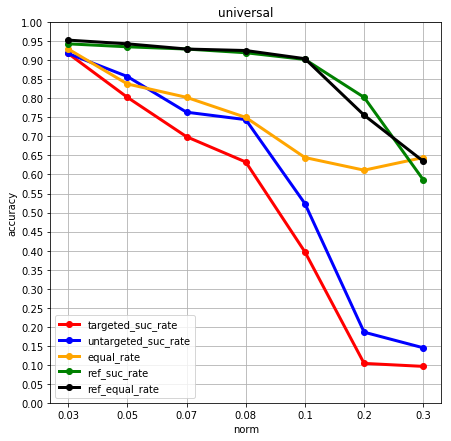

In [11]:
%reload_ext autoreload
%autoreload 2
from pert_universal import pert_universal
mean_channel = [0.4914, 0.4822, 0.4465]
std_channel = [0.2023, 0.1994, 0.2010]
def restore_fig(img):
    img = copy.deepcopy(img)
    for i in range(3):
        img[i, :, :] = 255 * (img[i, :, :] * std_channel[i] + mean_channel[i] + 1e-5)
    img = np.clip(img, 0, 255)
    
    img = img.astype(np.uint8)
    img = np.swapaxes(img, 0, 1)
    img = np.swapaxes(img, 1, 2)
    return img

def plot_img(img):
    #mport pdb
    #pdb.set_trace()
    plt.figure(figsize=(2, 2))
    plt.imshow(img)

    
def experiment_attack(net_set):
    for i in range(5):
        net_set[i].eval()
    
    for i in range(2):
        for j in range(i + 1, 2):
            acc_x, acc_y, equal_rate = [], [], []
            referred = []
            equal_rate2 = []
            for eps in [3e-2, 5e-2, 7e-2, 8e-2, 1e-1, 2e-1, 3e-1]:
                pert = pert_universal(testloader, device, net_set[i], epochs=1, delta=1, xi=eps * 32 * 1.7, p=2).detach()
                #import pdb
                #pdb.set_trace()
                acc1 = 0
                acc2 = 0
                acc3 = 0
                refer = 0
                equal = 0
                for batch_idx, (inputs, targets) in enumerate(testloader):
                    inps = inputs.to(device)
                    tgts = targets.to(device)
                    inps += pert
                    #tmp = inps.to("cpu").numpy()
                    #if batch_idx == 0:
                    #    plot_img(restore_fig(inputs[10].numpy()))
                    #    plot_img(restore_fig(tmp[10]))

                    oup1 = net_set[i](inps)
                    oup2 = net_set[j](inps)
                    _, pred1 = oup1.max(1)
                    _, pred2 = oup2.max(1)
                    acc1 += pred1.eq(tgts).sum().item()
                    acc2 += pred2.eq(tgts).sum().item()
                    acc3 += pred2.eq(pred1).sum().item()
                    
                
                    inps = inputs.to(device)
                    pert1 = torch.randn(inputs.shape).to(device)
                    pert1 = pert1 / torch.norm(pert1.reshape(targets.shape[0], -1), dim=1).reshape(targets.shape[0], 1, 1, 1)
                    pert2 = torch.randn(inputs.shape).to(device)
                    pert2 = pert2 / torch.norm(pert2.reshape(targets.shape[0], -1), dim=1).reshape(targets.shape[0], 1, 1, 1)
                    oup1 = net_set[i](inps + pert1 * eps * 32. * 1.7)
                    oup2 = net_set[j](inps + pert2 * eps * 32. * 1.7)
                    _, pred1 = oup1.max(1)
                    _, pred2 = oup2.max(1)
                    refer += pred1.eq(tgts).sum().item()
                    equal += pred2.eq(pred1).sum().item()
                    
                    print(batch_idx, end="")
                    if batch_idx >= 3:
                        break
                print("")
                
                acc1 /= 512
                acc2 /= 512
                acc3 /= 512
                refer /= 512
                equal /= 512
                acc_x.append(acc1)
                acc_y.append(acc2)
                equal_rate.append(acc3)
                referred.append(refer)
                equal_rate2.append(equal)
                print(acc1, acc2, acc3, refer, equal)
            plot_trend([3e-2, 5e-2, 7e-2, 8e-2, 1e-1, 2e-1, 3e-1], acc_x, acc_y, equal_rate, referred, equal_rate2, "universal")

                    
                
experiment_attack(net_set)

## Experiments that are not important

0.091796875 0.1337890625 0.6142578125
0.3154296875 0.48046875 0.6015625
0.3486328125 0.599609375 0.5625
0.7333984375 0.8330078125 0.8046875
0.94140625 0.94140625 0.9541015625

01234567
0.953125
01234567
0.955078125
01234567
0.951171875
01234567
0.94921875
01234567
0.939453125
01234567
0.91015625
01234567
0.7236328125
01234567
0.6474609375
01234567
0.8193359375


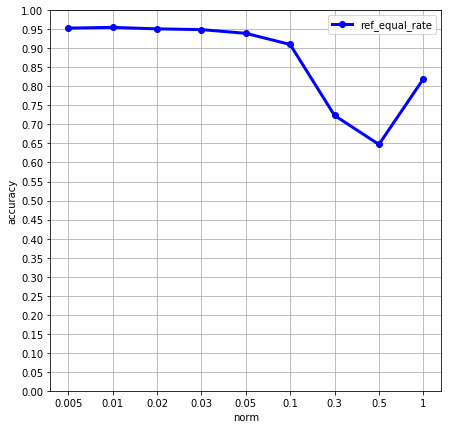

01234567
0.9501953125
01234567
0.951171875
01234567
0.955078125
01234567
0.9462890625
01234567
0.9443359375
01234567
0.9072265625
01234567
0.703125
01234567
0.6376953125
01234567
0.8798828125


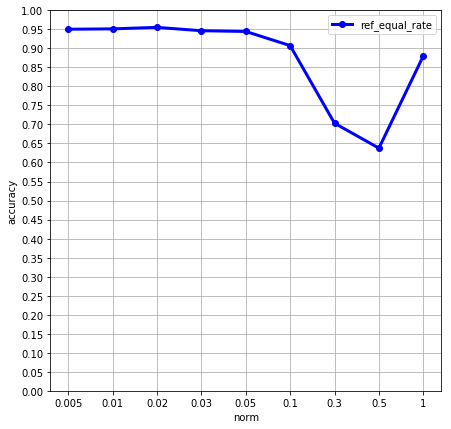

01234567
0.9482421875
01234567
0.947265625
01234567
0.947265625
01234567
0.9521484375
01234567
0.9326171875
01234567
0.8984375
01234567
0.71875
01234567
0.638671875
01234567
0.8173828125


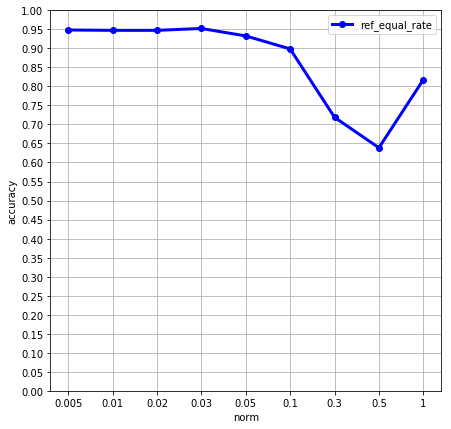

01234567
0.94921875
01234567
0.9462890625
01234567
0.9521484375
01234567
0.947265625
01234567
0.935546875
01234567
0.908203125
01234567
0.7294921875
01234567
0.607421875
01234567
0.82421875


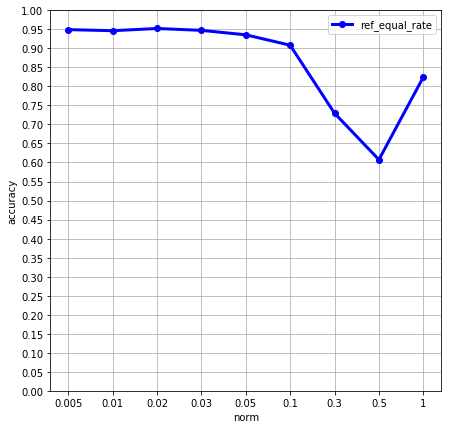

01234567
0.9609375
01234567
0.9619140625
01234567
0.958984375
01234567
0.953125
01234567
0.9501953125
01234567
0.8984375
01234567
0.72265625
01234567
0.654296875
01234567
0.796875


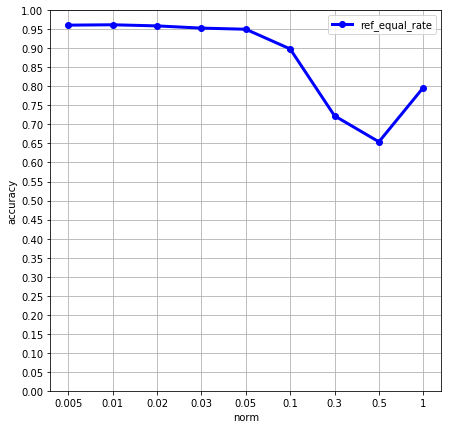

01234567
0.94921875
01234567
0.9462890625
01234567
0.9453125
01234567
0.951171875
01234567
0.9345703125
01234567
0.9072265625
01234567
0.728515625
01234567
0.6220703125
01234567
0.837890625


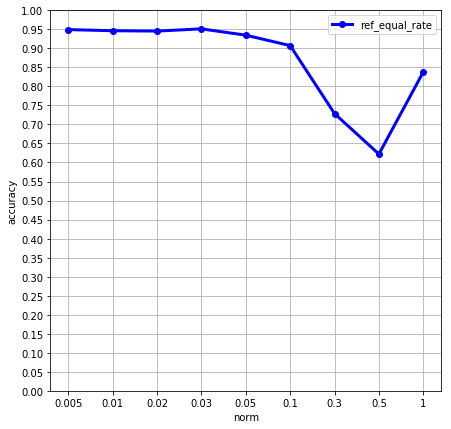

In [5]:
mean_channel = [0.4914, 0.4822, 0.4465]
std_channel = [0.2023, 0.1994, 0.2010]
def restore_fig(img):
    img = copy.deepcopy(img)
    for i in range(3):
        img[i, :, :] = 255 * (img[i, :, :] * std_channel[i] + mean_channel[i] + 1e-5)
    img = np.clip(img, 0, 255)
    
    img = img.astype(np.uint8)
    img = np.swapaxes(img, 0, 1)
    img = np.swapaxes(img, 1, 2)
    return img

def plot_img(img):
    #mport pdb
    #pdb.set_trace()
    plt.figure(figsize=(2, 2))
    plt.imshow(img)

def pertube(net, inps, targets, eps):
    length = 32. * 1.7
    iter_time = 5
    pert = torch.zeros(inps.shape, dtype=torch.float32).to(device)
    
    criterion = nn.CrossEntropyLoss()

    for i in range(iter_time):
        net.zero_grad()
        inputs = torch.autograd.Variable(inps - pert, requires_grad=True)
        outputs = net(inputs)
        #import pdb
        #pdb.set_trace()
        loss = criterion(outputs, targets)
        loss.backward()
        grad = inputs.grad.data
        grad = eps * length / 3 * grad / torch.norm(grad.reshape(targets.shape[0], -1), dim=1).reshape(targets.shape[0], 1, 1, 1)
        pert = pert + grad
        pert = eps * length * pert / torch.norm(pert.reshape(targets.shape[0], -1), dim=1).reshape(targets.shape[0], 1, 1, 1)
        pert = torch.clamp(pert, min=-1, max=1)
        
    return pert

    
def experiment_attack(net_set):
    for i in range(5):
        net_set[i].eval()
    
    for i in range(1, 5):
        for j in range(i + 1, 5):
            equal_rate = []
            for eps in [5e-3, 1e-2, 2e-2, 3e-2, 5e-2, 1e-1, 3e-1, 5e-1, 1]:
                equal = 0
                for batch_idx, (inputs, targets) in enumerate(testloader):
                    inps = inputs.to(device)
                    tgts = targets.to(device)
                    
                    inps = inputs.to(device)
                    pert1 = torch.randn(inputs.shape).to(device)
                    pert1 = pert1 / torch.norm(pert1.reshape(targets.shape[0], -1), dim=1).reshape(targets.shape[0], 1, 1, 1)
                    
                    oup1 = net_set[i](inps + pert1 * eps * 32. * 1.7)
                    oup2 = net_set[j](inps + pert1 * eps * 32. * 1.7)
                    _, pred1 = oup1.max(1)
                    _, pred2 = oup2.max(1)
                    equal += pred2.eq(pred1).sum().item()
                    
                    print(batch_idx, end="")
                    if batch_idx >= 7:
                        break
                print("")
                equal /= 1024
                equal_rate.append(equal)
                print(equal)
            
            index = [5e-3, 1e-2, 2e-2, 3e-2, 5e-2, 1e-1, 3e-1, 5e-1, 1]
            indexes = np.arange(1, len(index) + 1)
            fig = plt.figure(figsize=(7,7))
            plt.plot(indexes, equal_rate, marker="o", linewidth=3, label="ref_equal_rate", color="blue")
            plt.yticks(np.arange(0.0, 1.05, 0.05))
            plt.ylabel("accuracy")
            plt.xticks(indexes, index)
            plt.xlabel("norm")
            plt.legend()
            plt.grid()
            plt.show()

                    
                
experiment_attack(net_set)

0123
0.73046875 0.904296875 0.7734375 0.943359375 0.951171875
0123
0.330078125 0.779296875 0.48828125 0.943359375 0.9453125
0123
0.109375 0.673828125 0.359375 0.9375 0.9453125
0123
0.0 0.12890625 0.78125 0.91015625 0.8984375
0123
0.0 0.029296875 0.896484375 0.51953125 0.6015625
0123
0.0 0.029296875 0.81640625 0.1953125 0.576171875
0123
0.0 0.0703125 0.466796875 0.09765625 0.787109375


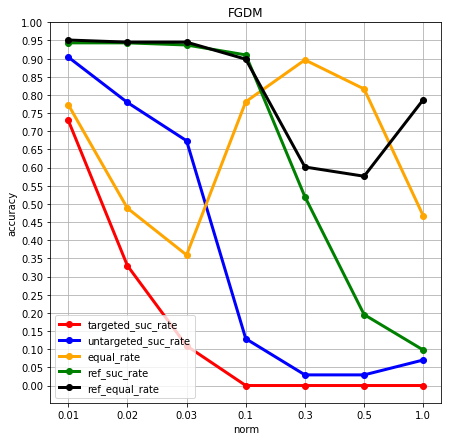

0123
0.724609375 0.876953125 0.7734375 0.947265625 0.9609375
0123
0.349609375 0.8203125 0.44921875 0.9453125 0.955078125
0123
0.10546875 0.6640625 0.361328125 0.947265625 0.9453125
0123
0.0 0.17578125 0.767578125 0.908203125 0.90625
0123
0.0 0.03125 0.876953125 0.51953125 0.658203125
0123
0.0 0.04296875 0.75390625 0.24609375 0.544921875
0123
0.0 0.064453125 0.451171875 0.109375 0.880859375


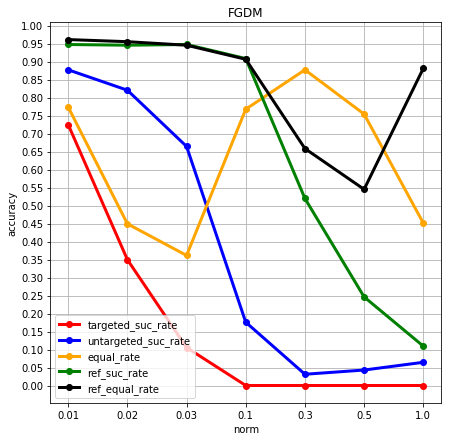

0123
0.732421875 0.87890625 0.75390625 0.951171875 0.953125
0123
0.33203125 0.79296875 0.462890625 0.94921875 0.953125
0123
0.09375 0.630859375 0.373046875 0.9453125 0.9375
0123
0.0 0.13671875 0.80859375 0.884765625 0.884765625
0123
0.0 0.03515625 0.865234375 0.501953125 0.638671875
0123
0.0 0.025390625 0.814453125 0.212890625 0.5546875
0123
0.0 0.080078125 0.48828125 0.11328125 0.791015625


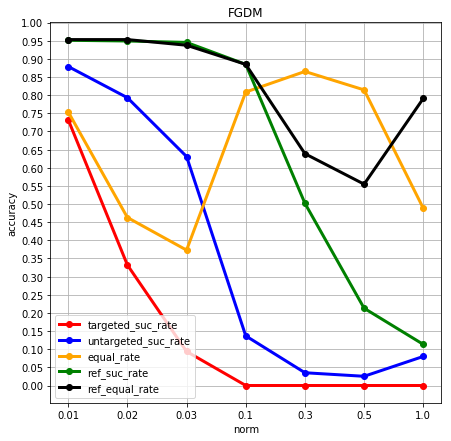

0123
0.75390625 0.876953125 0.791015625 0.947265625 0.9609375
0123
0.365234375 0.796875 0.470703125 0.947265625 0.962890625
0123
0.123046875 0.642578125 0.40234375 0.947265625 0.955078125
0123
0.0 0.1640625 0.783203125 0.90234375 0.89453125
0123
0.0 0.037109375 0.91015625 0.564453125 0.689453125
0123
0.0 0.033203125 0.830078125 0.22265625 0.537109375
0123
0.0 0.056640625 0.375 0.115234375 0.83203125


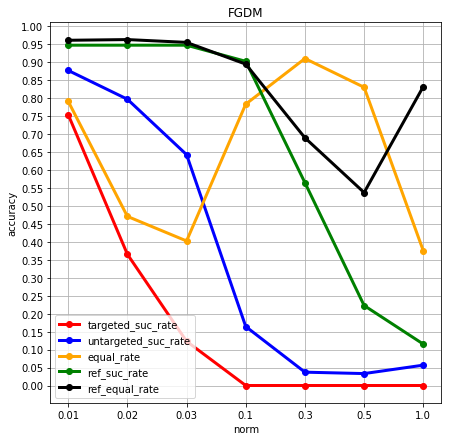

0123
0.759765625 0.8828125 0.771484375 0.947265625 0.96875
0123
0.35546875 0.7734375 0.5078125 0.947265625 0.96875
0123
0.12890625 0.64453125 0.390625 0.9453125 0.96875
012

KeyboardInterrupt: 

In [7]:
mean_channel = [0.4914, 0.4822, 0.4465]
std_channel = [0.2023, 0.1994, 0.2010]
def restore_fig(img):
    img = copy.deepcopy(img)
    for i in range(3):
        img[i, :, :] = 255 * (img[i, :, :] * std_channel[i] + mean_channel[i] + 1e-5)
    img = np.clip(img, 0, 255)
    
    img = img.astype(np.uint8)
    img = np.swapaxes(img, 0, 1)
    img = np.swapaxes(img, 1, 2)
    return img

def plot_img(img):
    #mport pdb
    #pdb.set_trace()
    plt.figure(figsize=(2, 2))
    plt.imshow(img)

def pertube(net, inps, targets, eps):
    length = 32. * 1.7
    iter_time = 20
    pert = torch.zeros(inps.shape, dtype=torch.float32).to(device)
    
    criterion = nn.CrossEntropyLoss()

    for i in range(iter_time):
        net.zero_grad()
        inputs = torch.autograd.Variable(inps - pert, requires_grad=True)
        outputs = net(inputs)
        #import pdb
        #pdb.set_trace()
        loss = criterion(outputs, targets)
        loss.backward()
        grad = inputs.grad.data
        grad = eps * length / 10 * grad / torch.norm(grad.reshape(targets.shape[0], -1), dim=1).reshape(targets.shape[0], 1, 1, 1)
        pert = pert + grad
        pert = eps * length * pert / torch.norm(pert.reshape(targets.shape[0], -1), dim=1).reshape(targets.shape[0], 1, 1, 1)
        pert = torch.clamp(pert, min=-1, max=1)
        
    return pert

    
def experiment_attack(net_set):
    for i in range(5):
        net_set[i].eval()
    
    for i in range(1, 5):
        for j in range(i + 1, 5):
            acc_x, acc_y, equal_rate = [], [], []
            referred = []
            equal_rate2 = []
            for eps in [1e-2, 2e-2, 3e-2, 5e-2, 1e-1, 3e-1, 5e-1, 1]:
                acc1 = 0
                acc2 = 0
                acc3 = 0
                refer = 0
                equal = 0
                for batch_idx, (inputs, targets) in enumerate(testloader):
                    inps = inputs.to(device)
                    tgts = targets.to(device)
                    fake = gen_dif(targets)
                    pert = pertube(net_set[i], inps, fake, eps)
                    inps -= pert
                    tmp = inps.to("cpu").numpy()
                    #import pdb
                    #pdb.set_trace()
                    if batch_idx == 0 and j == 1:
                        plot_img(restore_fig(inputs[10].numpy()))
                        plot_img(restore_fig(tmp[10]))

                    oup1 = net_set[i](inps)
                    oup2 = net_set[j](inps)
                    _, pred1 = oup1.max(1)
                    _, pred2 = oup2.max(1)
                    acc1 += pred1.eq(tgts).sum().item()
                    acc2 += pred2.eq(tgts).sum().item()
                    acc3 += pred2.eq(pred1).sum().item()
                    
                    inps = inputs.to(device)
                    pert1 = torch.randn(inputs.shape).to(device)
                    pert1 = pert1 / torch.norm(pert1.reshape(targets.shape[0], -1), dim=1).reshape(targets.shape[0], 1, 1, 1)
                    pert2 = torch.randn(inputs.shape).to(device)
                    pert2 = pert2 / torch.norm(pert2.reshape(targets.shape[0], -1), dim=1).reshape(targets.shape[0], 1, 1, 1)
                    oup1 = net_set[i](inps + pert1 * eps * 32. * 1.7)
                    oup2 = net_set[j](inps + pert2 * eps * 32. * 1.7)
                    _, pred1 = oup1.max(1)
                    _, pred2 = oup2.max(1)
                    refer += pred1.eq(tgts).sum().item()
                    equal += pred2.eq(pred1).sum().item()
                    
                    print(batch_idx, end="")
                    if batch_idx >= 3:
                        break
                print("")
                
                acc1 /= 512
                acc2 /= 512
                acc3 /= 512
                refer /= 512
                equal /= 512
                acc_x.append(acc1)
                acc_y.append(acc2)
                equal_rate.append(acc3)
                referred.append(refer)
                equal_rate2.append(equal)
                print(acc1, acc2, acc3, refer, equal)
            plot_trend([1e-2, 2e-2, 3e-2, 5e-2, 1e-1, 3e-1, 5e-1, 1], acc_x, acc_y, equal_rate, referred, equal_rate2, "FGDM")

                    
                
experiment_attack(net_set)

## Some tryouts

In [16]:
%reload_ext autoreload
%autoreload 2
from pert_universal import pert_universal
mean_channel = [0.4914, 0.4822, 0.4465]
std_channel = [0.2023, 0.1994, 0.2010]
def restore_fig(img):
    img = copy.deepcopy(img)
    for i in range(3):
        img[i, :, :] = 255 * (img[i, :, :] * std_channel[i] + mean_channel[i] + 1e-5)
    img = np.clip(img, 0, 255)
    
    img = img.astype(np.uint8)
    img = np.swapaxes(img, 0, 1)
    img = np.swapaxes(img, 1, 2)
    return img

def plot_img(img):
    #mport pdb
    #pdb.set_trace()
    plt.figure(figsize=(2, 2))
    plt.imshow(img)

def pertube(net, inps, targets, eps):
    length = 32. * 1.7
    iter_time = 5
    pert = torch.zeros(inps.shape, dtype=torch.float32).to(device)
    
    criterion = nn.CrossEntropyLoss()

    for i in range(iter_time):
        net.zero_grad()
        inputs = torch.autograd.Variable(inps - pert, requires_grad=True)
        outputs = net(inputs)
        #import pdb
        #pdb.set_trace()
        loss = criterion(outputs, targets)
        loss.backward()
        grad = inputs.grad.data
        grad = eps * length / 3 * grad / torch.norm(grad.reshape(targets.shape[0], -1), dim=1).reshape(targets.shape[0], 1, 1, 1)
        pert = pert + grad
        pert = eps * length * pert / torch.norm(pert.reshape(targets.shape[0], -1), dim=1).reshape(targets.shape[0], 1, 1, 1)
        pert = torch.clamp(pert, min=-1, max=1)
        
    return pert

from boundary import *
def experiment_attack(net_set):
    for i in range(5):
        net_set[i].eval()
    
    result = [[], []]
    for i in range(2):
        for j in range(i + 1, 2):
            pert_list = []
            
            for eps in [3e-2, 5e-2, 7e-2, 1e-1, 2e-1, 3e-1]:
                pert_list.append(pert_universal(testloader, device, net_set[i], epochs=1, delta=1, xi=eps * 32 * 1.7, p=2).detach())
            
            for tan in [0.05, 0.1, 0.2, 0.3, 0.5, 1, 2]:
                result[0].append(boundary(net_set[i], pert_list, device, testloader, tan=tan, samples = 10, average=True))
            for tan in [0.05, 0.1, 0.2, 0.3, 0.5, 1, 2]:
                result[1].append(boundary(net_set[j], pert_list, device, testloader, tan=tan, samples = 10, average=True))

    print(result)
    return result
result2 = experiment_attack(net_set)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68

epoch 0, batch 3, FOOLING RATE = 0.888672
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54

## Experiment #7
Exploring the property of boundary near the universal perturbation.

In [5]:
%reload_ext autoreload
%autoreload 2
from pert_universal import pert_universal
mean_channel = [0.4914, 0.4822, 0.4465]
std_channel = [0.2023, 0.1994, 0.2010]
def restore_fig(img):
    img = copy.deepcopy(img)
    for i in range(3):
        img[i, :, :] = 255 * (img[i, :, :] * std_channel[i] + mean_channel[i] + 1e-5)
    img = np.clip(img, 0, 255)
    
    img = img.astype(np.uint8)
    img = np.swapaxes(img, 0, 1)
    img = np.swapaxes(img, 1, 2)
    return img

def plot_img(img):
    #mport pdb
    #pdb.set_trace()
    plt.figure(figsize=(2, 2))
    plt.imshow(img)



from boundary import *
def experiment_attack(net_set):
    for i in range(5):
        net_set[i].eval()
    
    result = []
    for i in range(2):
        for j in range(i + 1, 2):
            pert_list = []
            
            for eps in [3e-2, 5e-2, 7e-2, 1e-1, 2e-1, 3e-1]:
                pert_list.append(pert_universal(testloader, device, net_set[i], epochs=1, delta=1, xi=eps * 32 * 1.7, p=2).detach())
            
            for tan in [0.05, 0.1, 0.2, 0.3, 0.5]:
                result.append(boundary2(net_set[i], net_set[j], pert_list, device, testloader, tan=tan, samples = 10, average=False))

    print(result)
    return result
result = experiment_attack(net_set)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68

125
126
127
epoch 0, batch 3, FOOLING RATE = 0.892578
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50

## Demonstrate the results of experiment #7

[[0.05273438 0.05273438 0.05253906 0.05195313 0.04785156 0.03261719
  0.02480469]
 [0.07578125 0.07480469 0.07402344 0.07460938 0.06953125 0.0515625
  0.040625  ]
 [0.50878906 0.50507813 0.49570313 0.47539063 0.42890625 0.28730469
  0.12675781]
 [0.73652344 0.73398438 0.72675781 0.71367187 0.68261719 0.52441406
  0.26738281]
 [0.88945312 0.88847656 0.88554687 0.88144531 0.8609375  0.79101562
  0.49472656]
 [0.91132813 0.90820312 0.90742188 0.903125   0.89238281 0.83125
  0.61269531]]
[[0.03535156 0.03535156 0.03554687 0.03535156 0.03496094 0.03242188
  0.01875   ]
 [0.07246094 0.07246094 0.07050781 0.06894531 0.06171875 0.04628906
  0.03535156]
 [0.31191406 0.31152344 0.30722656 0.30078125 0.27402344 0.19003906
  0.10117187]
 [0.60527344 0.60039062 0.58730469 0.57597656 0.52519531 0.403125
  0.22910156]
 [0.80605469 0.80429688 0.80253906 0.79375    0.77304688 0.68378906
  0.45      ]
 [0.859375   0.85664063 0.85097656 0.84492188 0.82734375 0.74570313
  0.57050781]]


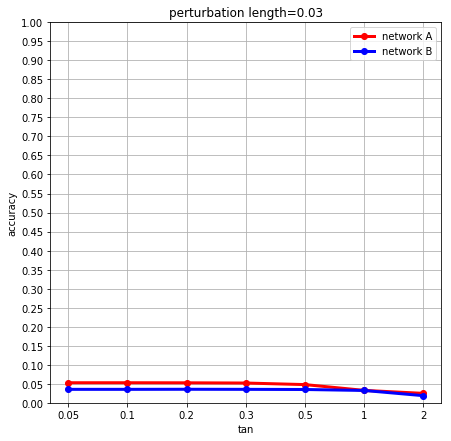

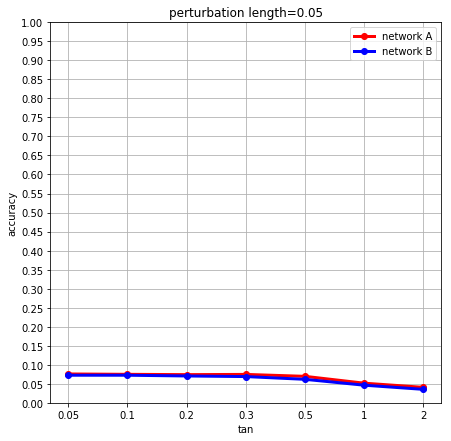

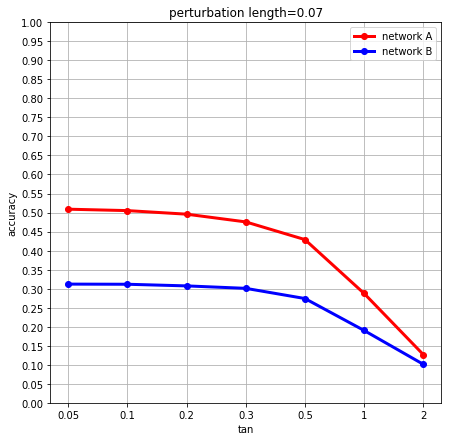

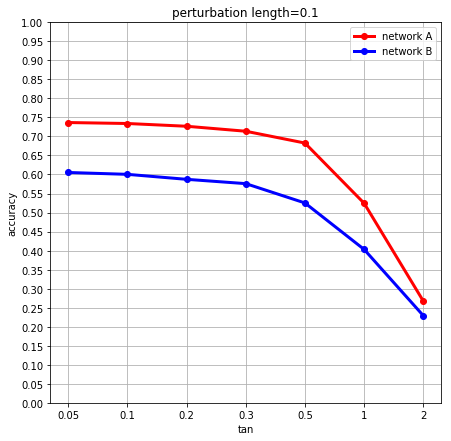

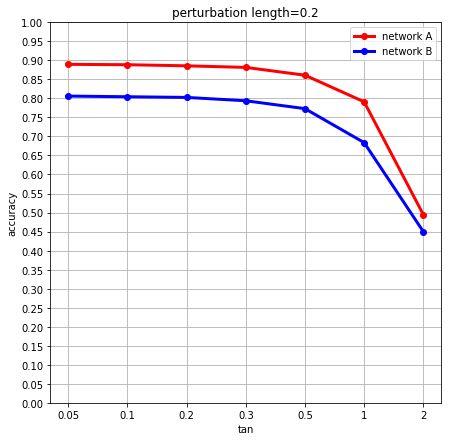

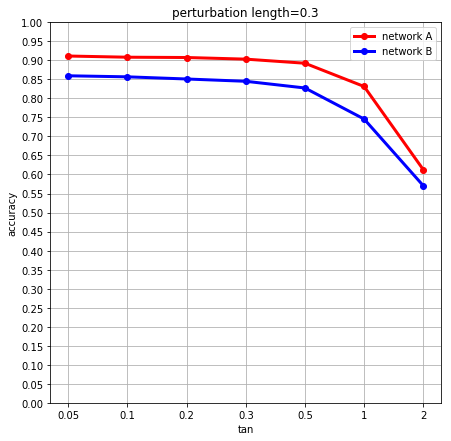

In [17]:
#a = np.array([np.array([0.05410156, 0.17519531, 0.44433594, 0.69960937, 0.89082031, 0.90234375]), np.array([0.05390625, 0.17519531, 0.44335938, 0.69726562, 0.88925781, 0.90253906]), np.array([0.05292969, 0.171875  , 0.43339844, 0.6921875 , 0.88925781,        0.89902344]), np.array([0.05058594, 0.16367187, 0.41875   , 0.68613281, 0.88417969, 0.8984375 ]), np.array([0.04570312, 0.14335938, 0.3828125 , 0.64082031, 0.8703125 ,  0.89023438])])
#b = np.array([np.array([0.04199219, 0.13964844, 0.32480469, 0.55214844, 0.80996094,        0.84121094]), np.array([0.04160156, 0.1390625 , 0.32421875, 0.54726562, 0.80976563,        0.84140625]), np.array([0.03964844, 0.13730469, 0.31894531, 0.54238281, 0.80605469,        0.8375    ]), np.array([0.04042969, 0.13261719, 0.30703125, 0.52539062, 0.8       ,        0.8359375 ]), np.array([0.03671875, 0.12128906, 0.27753906, 0.4796875 , 0.78261719,        0.81738281])])
a = result2[0]
b = result2[1]
a = np.transpose(a)
b = np.transpose(b)
print(a)
print(b)

for i in range(6):
    plt.figure(figsize=(7, 7))
    plt.plot(np.arange(7), a[i], marker='o', linewidth=3, label="network A", color="r")
    plt.plot(np.arange(7), b[i], marker='o', linewidth=3, label="network B", color="b")
    plt.title("perturbation length={}".format([3e-2, 5e-2, 7e-2, 1e-1, 2e-1, 3e-1][i]))
    plt.yticks(np.arange(0.0, 1.05, 0.05))
    plt.ylabel("accuracy")
    plt.xticks(np.arange(7), [0.05, 0.1, 0.2, 0.3, 0.5, 1, 2])
    plt.xlabel("tan")
    plt.legend()
    plt.grid()
    plt.show()

## Below are unimportant experiment attempts

0.6080332409972299
0.6022727272727273
0.6319875776397516
0.6366237482117311
0.6555851063829787
0.5909090909090909
0.6338418862690708
0.6157205240174672
0.6423562412342216
0.6365030674846626


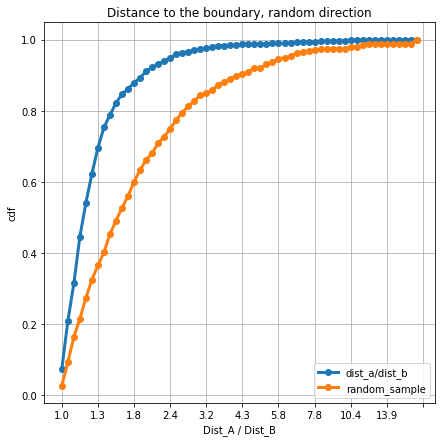

In [5]:
mean_channel = [0.4914, 0.4822, 0.4465]
std_channel = [0.2023, 0.1994, 0.2010]
def restore_fig(img):
    img = copy.deepcopy(img)
    for i in range(3):
        img[i, :, :] = 255 * (img[i, :, :] * std_channel[i] + mean_channel[i] + 1e-5)
    img = np.clip(img, 0, 255)
    
    img = img.astype(np.uint8)
    img = np.swapaxes(img, 0, 1)
    img = np.swapaxes(img, 1, 2)
    return img

def plot_img(img):
    #mport pdb
    #pdb.set_trace()
    plt.figure(figsize=(2, 2))
    plt.imshow(img)

import random
eps = [5e-4]
power = 1.05
powers = [1]
while eps[-1] <= 0.5:
    eps.append(eps[-1] * power)
    powers.append(powers[-1]*power)


def experiment_attack3(net_set):
    for i in range(5):
        net_set[i].eval()
    
    for i in range(5):
        for j in range(i + 1, 5):
            ratio = []
            acc = 0
            for batch_idx, (inputs, targets) in enumerate(testloader):
                inputs = inputs.to(device)
                targets = targets.to(device)
                pert = torch.randn(inputs.shape).to(device)
                pert = pert / torch.norm(pert.reshape(targets.shape[0], -1), dim=1).reshape(targets.shape[0], 1, 1, 1)
                
                if batch_idx == 0:
                    inps = copy.deepcopy((inputs + pert * 1 * 32 * 1.7)[10].to("cpu").numpy())
                    #pdb.set_trace()
                    #plot_img(restore_fig(inps))
                
                result1 = []
                result2 = []
                predict1 = []
                predict2 = []
                for eps_i in range(len(eps)):
                    inps = inputs + pert * eps[eps_i] * 32. * 1.7
                    tmp = inps.to("cpu").numpy()

                    oup1 = net_set[i](inps)
                    oup2 = net_set[j](inps)
                    _, pred1 = oup1.max(1)
                    _, pred2 = oup2.max(1)
                    res1 = copy.deepcopy(pred1.eq(targets).to("cpu").numpy())
                    res2 = copy.deepcopy(pred2.eq(targets).to("cpu").numpy())
                    result1.append(res1)
                    result2.append(res2)
                    predict1.append(copy.deepcopy(pred1.to("cpu").numpy()))
                    predict2.append(copy.deepcopy(pred2.to("cpu").numpy()))
                
                result1 = np.array(result1)
                result2 = np.array(result2)
                predict1 = np.array(predict1)
                predict2 = np.array(predict2)
                #pdb.set_trace()
                for sample in range(targets.shape[0]):
                    first_i = 0
                    first_j = 0
                    for eps_i in range(len(eps)):
                        if result1[eps_i][sample] == 0 and not first_i:
                            first_i = eps_i + 1
                        if result2[eps_i][sample] == 0 and not first_j:
                            first_j = eps_i + 1
                    if not first_i:
                        first_i = len(eps)
                    if not first_j:
                        first_j = len(eps)
                    if first_i > first_j:
                        first_i2, first_j2 = first_j, first_i
                    else:
                        first_i2, first_j2 = first_i, first_j
                    
                    if first_i2 > 1 and first_j2 < len(eps):
                        #pdb.set_trace()
                        ratio.append([eps[first_j2 - 1] / eps[first_i2 - 1], first_i2, first_j2])
                        acc += predict1[first_i - 1][sample] == predict2[first_j - 1][sample]
                #print(batch_idx)
                if batch_idx >= 8:
                    break
            #pdb.set_trace()
            print(acc / len(ratio))
    return ratio
        
ratio = experiment_attack3(net_set)
#ratio = [[1.2155062500000002, 119, 123], [1.4774554437890632, 122, 130], [1.4774554437890632, 124, 132], [1.1025, 118, 120], [1.2155062500000005, 125, 129], [1.05, 125, 126], [2.078928179411368, 107, 122], [1.2155062500000002, 118, 122], [1.05, 124, 125], [1.0, 129, 129], [1.0, 130, 130], [1.2762815625000001, 118, 123], [1.05, 130, 131], [1.1576250000000003, 128, 131], [2.4066192336910848, 106, 124], [1.7103393581163142, 118, 129], [1.1025, 126, 128], [2.292018317801034, 115, 132], [1.21550625, 115, 119], [1.2762815625000006, 126, 131], [1.4774554437890628, 106, 114], [1.2762815625000004, 122, 127], [1.05, 129, 130], [1.9799315994393978, 108, 122], [1.05, 126, 127], [1.05, 114, 115], [1.05, 128, 129], [1.4774554437890626, 113, 121], [1.1025000000000003, 125, 127], [1.05, 131, 132], [1.9799315994393987, 88, 102], [1.05, 127, 128], [1.3400956406250006, 126, 132], [1.2155062500000005, 126, 130], [2.9252607199217255, 110, 132], [1.7103393581163142, 118, 129], [1.477455443789063, 120, 128], [1.1576250000000001, 123, 126], [1.05, 130, 131], [1.2762815625000004, 122, 127], [1.3400956406250006, 126, 132], [1.1025, 101, 103], [1.4071004226562502, 115, 122], [1.0, 124, 124], [1.3400956406250006, 126, 132], [1.05, 129, 130], [1.79585632602213, 96, 108], [1.4774554437890626, 114, 122], [1.05, 130, 131], [1.05, 130, 131], [1.05, 130, 131], [1.3400956406250006, 125, 131], [5.003188542033791, 84, 117], [1.05, 122, 123], [1.0, 129, 129], [5.003188542033794, 67, 100], [2.6532977051444218, 111, 131], [1.1025, 126, 128], [3.3863549408993876, 107, 132], [1.1576250000000003, 128, 131], [1.1025000000000003, 128, 130], [1.885649142323236, 112, 125], [1.3400956406250006, 126, 132], [1.3400956406250004, 123, 129], [1.340095640625, 114, 120], [1.8856491423232364, 116, 129], [1.2155062500000002, 124, 128], [1.2762815625000001, 123, 128], [1.05, 125, 126], [1.157625, 112, 115], [1.2155062500000002, 124, 128], [1.0, 121, 121], [1.0, 130, 130], [1.7958563260221296, 104, 116], [1.05, 127, 128], [1.05, 128, 129], [1.4071004226562507, 125, 132], [1.1025, 119, 121], [1.157625, 116, 119], [1.05, 130, 131], [2.1828745883819374, 92, 108], [1.3400956406250006, 126, 132], [1.21550625, 111, 115], [1.3400956406250002, 102, 108], [6.385477289908985, 82, 120], [1.05, 127, 128], [1.0, 126, 126], [1.0, 102, 102], [3.0715237559178123, 77, 100], [1.4071004226562502, 117, 124], [1.1576250000000001, 109, 112], [1.1576250000000003, 127, 130], [10.921333129289236, 81, 130], [1.05, 128, 129], [1.551328215978516, 115, 124], [2.182874588381937, 116, 132], [1.6288946267774418, 102, 112], [3.225099943713702, 94, 118], [1.2155062500000002, 107, 111], [1.2155062500000005, 128, 132], [1.3400956406250002, 110, 116], [1.1025, 130, 132], [1.05, 126, 127], [1.05, 123, 124], [1.1025, 130, 132], [1.05, 126, 127], [1.4774554437890628, 118, 126], [1.1025, 124, 126], [1.1025, 126, 128], [1.551328215978516, 117, 126], [1.7103393581163147, 91, 102], [1.1025000000000003, 127, 129], [1.3400956406250006, 124, 130], [1.05, 129, 130], [1.1025000000000003, 129, 131], [1.2155062500000002, 122, 126], [1.4774554437890628, 115, 123], [1.6288946267774422, 94, 104], [1.05, 128, 129], [1.05, 116, 117], [1.05, 129, 130], [1.05, 128, 129], [1.05, 116, 117], [1.40710042265625, 112, 119], [1.6288946267774422, 119, 129], [10.921333129289236, 72, 121], [5.003188542033791, 96, 129], [1.7103393581163147, 121, 132], [1.2762815625000004, 124, 129], [3.555672687944356, 102, 128], [1.0, 122, 122], [1.4774554437890626, 110, 118], [1.05, 128, 129], [1.710339358116314, 115, 126], [1.2762815625000004, 122, 127], [1.2155062500000002, 106, 110], [1.1576250000000001, 124, 127], [1.1025000000000003, 129, 131], [1.1025000000000003, 129, 131], [1.7958563260221299, 115, 127], [2.5269501953756395, 104, 123], [1.0, 130, 130], [1.2762815625000006, 125, 130], [1.05, 129, 130], [1.1025, 130, 132], [1.2155062500000005, 126, 130], [1.0, 128, 128], [1.6288946267774422, 122, 132], [1.1025, 130, 132], [1.3400956406250004, 123, 129], [5.003188542033791, 96, 129], [1.477455443789063, 97, 105], [1.0, 118, 118], [3.225099943713702, 105, 129], [1.7958563260221296, 102, 114], [1.628894626777442, 118, 128], [1.1025, 124, 126], [1.1576250000000003, 128, 131], [1.2762815625000001, 120, 125], [1.2155062500000005, 126, 130], [1.4071004226562507, 125, 132], [1.477455443789063, 121, 129], [1.1025, 119, 121], [1.1025, 120, 122], [1.1576250000000003, 129, 132], [1.2762815625, 115, 120], [1.0, 110, 110], [1.05, 129, 130], [1.79585632602213, 82, 94], [1.4071004226562507, 125, 132], [1.6288946267774418, 101, 111], [1.5513282159785164, 120, 129], [1.1025, 124, 126], [2.182874588381937, 114, 130], [1.0, 121, 121], [1.1025000000000003, 125, 127], [1.2155062500000002, 99, 103], [1.1025, 121, 123], [1.7103393581163147, 121, 132], [1.1025000000000003, 129, 131], [1.40710042265625, 112, 119], [1.1576250000000003, 126, 129], [1.05, 126, 127], [1.2155062500000005, 127, 131], [1.1576250000000001, 122, 125], [1.157625, 114, 117], [1.0, 131, 131], [1.628894626777442, 117, 127], [2.5269501953756395, 108, 127], [1.3400956406250002, 117, 123], [1.9799315994393978, 104, 118], [1.0, 126, 126], [2.2920183178010336, 114, 131], [1.885649142323236, 113, 126], [1.0, 131, 131], [1.3400956406250004, 120, 126], [1.157625, 114, 117], [1.1576250000000003, 126, 129], [1.2155062500000005, 125, 129], [1.7958563260221294, 112, 124], [1.21550625, 115, 119], [1.2762815625000001, 123, 128], [1.1576250000000003, 127, 130], [1.3400956406250002, 107, 113], [1.9799315994393978, 104, 118], [1.05, 128, 129], [1.2155062500000002, 121, 125], [1.1576250000000001, 122, 125], [1.551328215978516, 119, 128], [1.1576250000000001, 118, 121], [1.1576250000000001, 121, 124], [1.2762815625000001, 118, 123], [1.05, 130, 131], [2.2920183178010336, 112, 129], [1.0, 119, 119], [1.1025, 122, 124], [3.9201291384586554, 80, 108], [1.2155062500000002, 119, 123], [1.1025, 114, 116], [2.182874588381937, 114, 130], [1.2762815625000001, 106, 111], [1.6288946267774418, 107, 117], [1.0, 115, 115], [2.5269501953756395, 110, 129], [1.2762815625000001, 118, 123], [1.1025, 126, 128], [1.1576250000000003, 129, 132], [1.0, 117, 117], [1.0, 129, 129], [1.7103393581163138, 113, 124], [1.40710042265625, 114, 121], [1.05, 127, 128], [1.1025000000000003, 128, 130], [1.340095640625, 113, 119], [1.1576250000000003, 128, 131], [1.1025, 130, 132], [1.551328215978516, 119, 128], [1.4774554437890632, 123, 131], [1.1576250000000003, 126, 129], [1.2155062500000005, 125, 129], [1.4774554437890632, 122, 130], [3.3863549408993876, 93, 118], [4.5380394939082, 87, 118], [1.4071004226562505, 120, 127], [1.2155062500000002, 107, 111], [1.1576250000000003, 127, 130], [1.3400956406250002, 118, 124], [1.3400956406250004, 82, 88], [1.2155062500000002, 108, 112], [1.6288946267774418, 107, 117], [1.1025, 117, 119], [1.05, 119, 120], [1.885649142323236, 109, 122], [1.2762815625000004, 127, 132], [1.2155062500000005, 126, 130], [7.391988147730888, 84, 125], [1.05, 118, 119], [1.4071004226562507, 124, 131], [1.2762815625000001, 123, 128], [1.1025000000000003, 127, 129], [1.1025, 114, 116], [1.1025, 124, 126], [1.2762815625000004, 122, 127], [1.1025000000000003, 128, 130], [1.2762815625000001, 123, 128], [1.4071004226562502, 119, 126], [1.05, 115, 116], [1.1576250000000001, 124, 127], [2.078928179411368, 113, 128], [1.2762815625000006, 126, 131], [1.5513282159785164, 123, 132], [1.4774554437890626, 114, 122], [1.2762815625, 115, 120], [1.1576250000000001, 106, 109], [1.4071004226562502, 108, 115], [1.1576250000000001, 124, 127], [1.2762815625000004, 124, 129], [20.593802448270598, 64, 126], [1.0, 129, 129], [1.3400956406250002, 111, 117], [1.0, 126, 126], [1.1025000000000003, 125, 127], [1.0, 121, 121], [1.05, 121, 122], [1.1025, 130, 132], [1.4071004226562505, 90, 97], [2.7859625904016427, 96, 117], [1.4071004226562502, 108, 115], [1.477455443789063, 120, 128], [1.1576250000000003, 126, 129], [1.1576250000000001, 119, 122], [1.1025, 130, 132], [1.2762815625000001, 108, 113], [1.40710042265625, 113, 120], [1.157625, 112, 115], [1.2155062500000005, 127, 131], [1.1025, 130, 132], [4.116135595381587, 98, 127], [1.1025, 108, 110], [2.078928179411368, 110, 125], [1.9799315994393978, 111, 125], [1.0, 128, 128], [1.2155062500000005, 125, 129], [1.2155062500000002, 119, 123], [1.1576250000000001, 122, 125], [1.1576250000000003, 127, 130], [3.555672687944357, 105, 131], [1.5513282159785158, 113, 122], [1.2762815625000001, 109, 114], [1.0, 113, 113], [1.5513282159785162, 96, 105], [1.1025, 130, 132], [3.555672687944357, 105, 131], [1.1576250000000001, 121, 124], [16.942572239567337, 67, 125], [1.8856491423232369, 90, 103], [1.05, 109, 110], [1.4071004226562502, 118, 125], [1.7958563260221296, 110, 122], [1.05, 121, 122], [1.3400956406250004, 123, 129], [1.3400956406250002, 122, 128], [1.1025, 130, 132], [1.2762815625000004, 124, 129], [1.1025, 117, 119], [1.1576250000000001, 125, 128], [1.7958563260221294, 109, 121], [1.1025, 130, 132], [1.05, 121, 122]]
bins = np.zeros(60)
for item in ratio:
    bins[min(59, item[2] - item[1])] += 1
for i in range(1, 60):
    bins[i] += bins[i - 1]
bins /= bins[-1]
bins2 = bins
    
index = np.array(powers[0:60])
plt.figure(figsize=(7,7))
plt.plot(np.arange(60), bins, marker='o', linewidth=3, label="dist_a/dist_b")

bins = np.zeros(60)
for i in range(1000):
    x = random.randint(0, len(ratio) - 1)
    y = random.randint(0, len(ratio) - 1)
    bins[min(59, abs(ratio[x][1] - ratio[y][1]))] += 1
for i in range(1, 60):
    bins[i] += bins[i - 1]
bins /= bins[-1]
index = np.around(np.array(powers[0:60]), decimals=1)

plt.plot(np.arange(60), bins, marker='o', linewidth=3, label="random_sample")
plt.xticks(np.arange(11) * 6, index[0:-1:6])
plt.xlabel("Dist_A / Dist_B")
plt.ylabel("cdf")
plt.title("Distance to the boundary, random direction")
plt.grid()
plt.legend()
plt.show()

0.48
0.4777227722772277
0.4883435582822086
0.48488664987405544
0.44583808437856326
0.45691609977324266
0.46835443037974683
0.4741275571600481
0.5047281323877069


No handles with labels found to put in legend.


0.45629820051413883


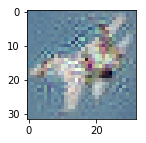

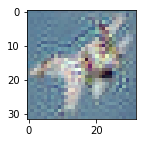

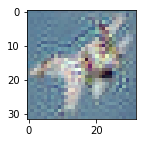

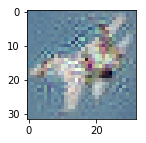

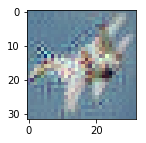

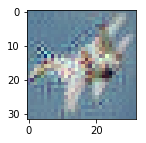

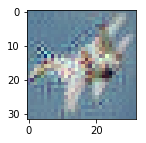

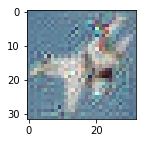

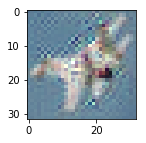

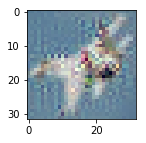

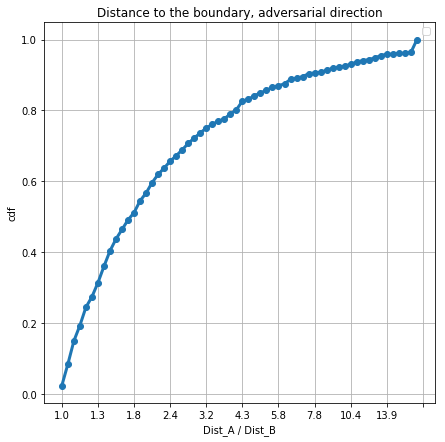

In [8]:
mean_channel = [0.4914, 0.4822, 0.4465]
std_channel = [0.2023, 0.1994, 0.2010]
def restore_fig(img):
    img = copy.deepcopy(img)
    for i in range(3):
        img[i, :, :] = 255 * (img[i, :, :] * std_channel[i] + mean_channel[i] + 1e-5)
    img = np.clip(img, 0, 255)
    
    img = img.astype(np.uint8)
    img = np.swapaxes(img, 0, 1)
    img = np.swapaxes(img, 1, 2)
    return img

def plot_img(img):
    #mport pdb
    #pdb.set_trace()
    plt.figure(figsize=(2, 2))
    plt.imshow(img)

import random
eps = [5e-4]
power = 1.05
powers = [1]
while eps[-1] <= 0.5:
    eps.append(eps[-1] * power)
    powers.append(powers[-1]*power)

def gen_grad(net, inputs, targets):
    #pdb.set_trace()
    net.zero_grad()
    inputs = torch.autograd.Variable(inputs, requires_grad=True)
    criterion = nn.CrossEntropyLoss()
    outputs = net(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    pert = inputs.grad.data
    return pert / torch.norm(pert.reshape(targets.shape[0], -1), dim=1).reshape(targets.shape[0], 1, 1, 1)
    
    

def experiment_attack4(net_set):
    for i in range(5):
        net_set[i].eval()
    
    for i in range(5):
        for j in range(i + 1, 5):
            ratio = []
            acc = 0
            for batch_idx, (inputs, targets) in enumerate(testloader):
                inputs = inputs.to(device)
                targets = targets.to(device)
                #pdb.set_trace()
                pert = gen_grad(net_set[i], inputs, gen_dif(targets))
                
                if batch_idx == 0:
                    inps = copy.deepcopy((inputs - pert * 0.3 * 32 * 1.7)[10].to("cpu").numpy())
                    #pdb.set_trace()
                    plot_img(restore_fig(inps))
                
                result1 = []
                result2 = []
                predict1 = []
                predict2 = []
                for eps_i in range(len(eps)):
                    inps = inputs - pert * eps[eps_i] * 32. * 1.7
                    tmp = inps.to("cpu").numpy()

                    oup1 = net_set[i](inps)
                    oup2 = net_set[j](inps)
                    _, pred1 = oup1.max(1)
                    _, pred2 = oup2.max(1)
                    res1 = copy.deepcopy(pred1.eq(targets).to("cpu").numpy())
                    res2 = copy.deepcopy(pred2.eq(targets).to("cpu").numpy())
                    result1.append(res1)
                    result2.append(res2)
                    predict1.append(copy.deepcopy(pred1.to("cpu").numpy()))
                    predict2.append(copy.deepcopy(pred2.to("cpu").numpy()))

                
                result1 = np.array(result1)
                result2 = np.array(result2)
                
                for sample in range(targets.shape[0]):
                    first_i = 0
                    first_j = 0
                    for eps_i in range(len(eps)):
                        if result1[eps_i][sample] == 0 and not first_i:
                            first_i = eps_i + 1
                        if result2[eps_i][sample] == 0 and not first_j:
                            first_j = eps_i + 1
                    if not first_i:
                        first_i = len(eps)
                    if not first_j:
                        first_j = len(eps)
                    if first_i > first_j:
                        first_i, first_j = first_j, first_i
                    
                    if first_i > 1 and first_j < len(eps):
                        ratio.append([eps[first_j - 1] / eps[first_i - 1], first_i, first_j])
                        acc += predict1[first_i - 1][sample] == predict2[first_j - 1][sample]
                #print(batch_idx)
                if batch_idx >= 8:
                    break
            #pdb.set_trace()
            acc /= len(ratio)
            #print(ratio)
            print(acc)
    return ratio
        
ratio = experiment_attack4(net_set)
bins = np.zeros(60)
for item in ratio:
    bins[min(59, item[2] - item[1])] += 1
for i in range(1, 60):
    bins[i] += bins[i - 1]
bins /= bins[-1]
    
index = np.around(np.array(powers[0:60]), decimals=1)

plt.figure(figsize=(7,7))
plt.plot(np.arange(60), bins, marker='o', linewidth=3)
plt.xticks(np.arange(11) * 6, index[0:-1:6])
plt.xlabel("Dist_A / Dist_B")
plt.ylabel("cdf")
plt.title("Distance to the boundary, adversarial direction")
plt.grid()
plt.legend()
plt.show()